## Imports

In [4]:
!pip install gensim

In [2]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 8.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you hav

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [6]:
# Para el error raro de gensim
!pip uninstall -y scipy
!pip install --no-cache-dir scipy

Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 184.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.


In [3]:
import os
import re
import spacy
import html
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
import pyLDAvis
import pyLDAvis.gensim
import gensim.downloader

from math import sqrt
from datasets import Dataset
from wordcloud import WordCloud
from transformers import pipeline
from tqdm import tqdm
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from transformers import BertTokenizer, BertModel
from datasets import Dataset
from transformers import pipeline
from gensim import corpora, models
from gensim.models import KeyedVectors, LdaModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

## Board Games Data Loading

Firstly, we load the data scraped from the BGG website (https://boardgamegeek.com). This dataset contains the following features: game name, description, year, rating, complexity, minplayers, maxplayers, playingtime, minage and categories

In [5]:
filename = "boardgames_4122.csv"
games = pd.read_csv(filename, sep=";")
games.head()

,id,name,description,year,rating,complexity,minplayers,maxplayers,playingtime,minage,categories
0,1,Die Macher,Die Macher is a game about seven sequential po...,1986,7.58777,4.3081,3,5,240,14,"Economic, Negotiation, Political"
1,2,Dragonmaster,Dragonmaster is a trick-taking card game based...,1981,6.66468,1.9643,3,4,30,12,"Card Game, Fantasy"
2,3,Samurai,Samurai is set in medieval Japan. Players comp...,1998,7.47596,2.4420,2,4,60,10,"Abstract Strategy, Medieval"
3,4,Tal der Könige,When you see the triangular box and the luxuri...,1992,6.61540,2.6875,2,4,60,12,Ancient
4,5,Acquire,"In Acquire, each player strategically invests ...",1964,7.35053,2.4923,2,6,90,12,"Economic, Territory Building"


### Board Games Dataset Exploration

Before preprocessing the descriptions, we will perform a few data exploration steps to understand the dataset

In [6]:
# Missing Value information
print("Dataset Info:")
print(games.info())
print("\nMissing Values:\n", games.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4122 entries, 0 to 4121
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           4122 non-null   int64  
 1   name         4122 non-null   object 
 2   description  4122 non-null   object 
 3   year         4122 non-null   int64  
 4   rating       4122 non-null   float64
 5   complexity   4122 non-null   float64
 6   minplayers   4122 non-null   int64  
 7   maxplayers   4122 non-null   int64  
 8   playingtime  4122 non-null   int64  
 9   minage       4122 non-null   int64  
 10  categories   4068 non-null   object 
dtypes: float64(2), int64(6), object(3)
memory usage: 354.4+ KB
None

Missing Values:
 id              0
name            0
description     0
year            0
rating          0
complexity      0
minplayers      0
maxplayers      0
playingtime     0
minage          0
categories     54
dtype: int64


As one can observe, the are only a few NA values. The descriptions feature, which is the important variable for NLP processing, has zero NA values.

Observing the summaries of the numerical features is useful to later apply filtering of games:

In [7]:
# Summary statistics
print("\nSummary Statistics:")
print(games.describe())


Summary Statistics:
                id         year       rating   complexity   minplayers  \
count  4122.000000  4122.000000  4122.000000  4122.000000  4122.000000   
mean   3211.712033  1958.408782     5.695177     1.717946     2.162300   
std    1733.068617   267.545357     1.337350     1.001928     0.907306   
min       1.000000 -3000.000000     0.000000     0.000000     0.000000   
25%    1791.250000  1981.000000     5.210215     1.063275     2.000000   
50%    3349.500000  1991.000000     5.902780     1.685500     2.000000   
75%    4695.500000  1998.000000     6.500000     2.383900     2.000000   
max    6000.000000  2012.000000     9.500000     5.000000    10.000000   

        maxplayers   playingtime       minage  
count  4122.000000   4122.000000  4122.000000  
mean      5.581029    113.636827     9.092431  
std      10.144807    985.820912     3.885081  
min       0.000000      0.000000     0.000000  
25%       2.000000     30.000000     8.000000  
50%       4.000000     6

Now we will observe the categories count to see what are the most common ones:

In [8]:
# Categorical overview
print("\nUnique Categories Count:")
print(games['categories'].nunique())

print("\nMost Common Categories:")
print(games['categories'].value_counts().head(10))


Unique Categories Count:
1704

Most Common Categories:
categories
Abstract Strategy              229
Card Game                      200
Wargame, World War II          145
Economic                        79
Science Fiction, Wargame        53
Sports                          47
Dice                            45
Deduction, Murder / Mystery     43
Word Game                       35
Modern Warfare, Wargame         33
Name: count, dtype: int64


Most of the games inside the dataset are either card games or abstract strategy.

Let's now observe the distributions of the numerical variables

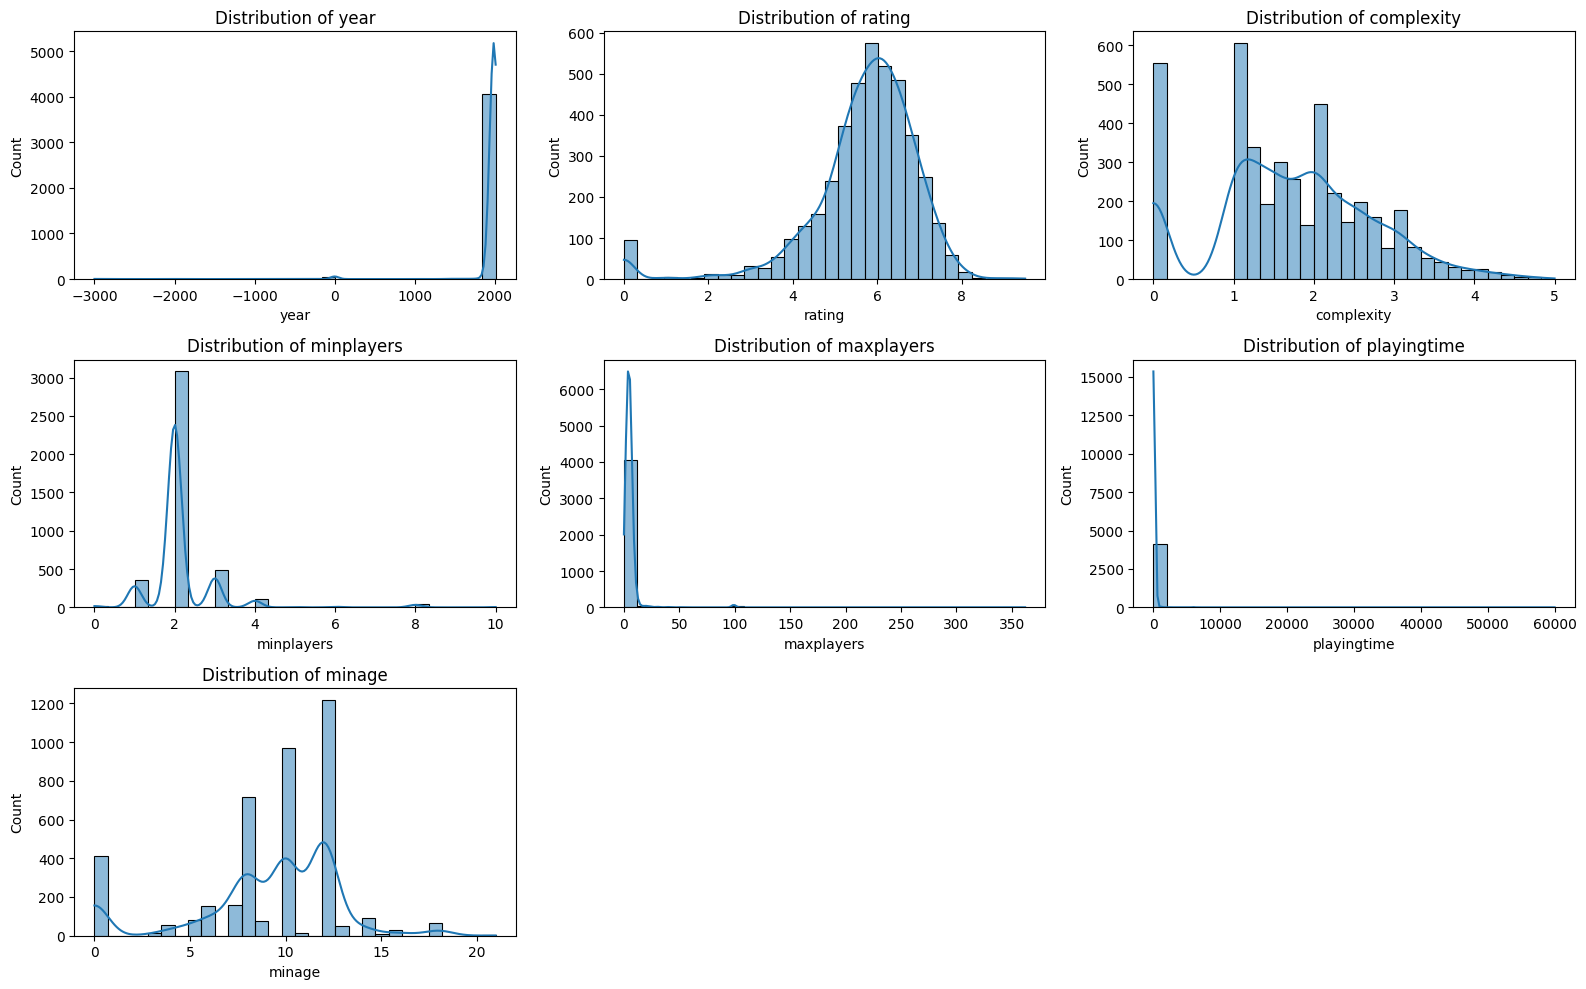

In [9]:
# Distribution plots
numeric_features = ['year', 'rating', 'complexity', 'minplayers', 'maxplayers', 'playingtime', 'minage']

plt.figure(figsize=(16, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(games[feature].dropna(), kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

We can see that the mean rating of the games is around 6, and that most of the games are recent. However, there are some outlier games whose year of creation is before Christ, these are the following:

In [10]:
# Filter games year of creation below 0
invalid_year_games = games[games['year'] < 0]

# Display the results
print("Games with year < 0:")
print(invalid_year_games[['id', 'name', 'year']])

Games with year < 0:
        id                                      name  year
129    188                                        Go -2200
924   1602                      The Royal Game of Ur -2600
1734  2912  Hounds and Jackals: Game of the Pharaohs -2000
2464  3886                         Nine Men's Morris -1400
2694  4148                                     Mehen -3000
3658  5432                        Chutes and Ladders  -200
3755  5546                                   Marbles -3000


These games are mostly from Egypt

Let's observe the correlation between variables.

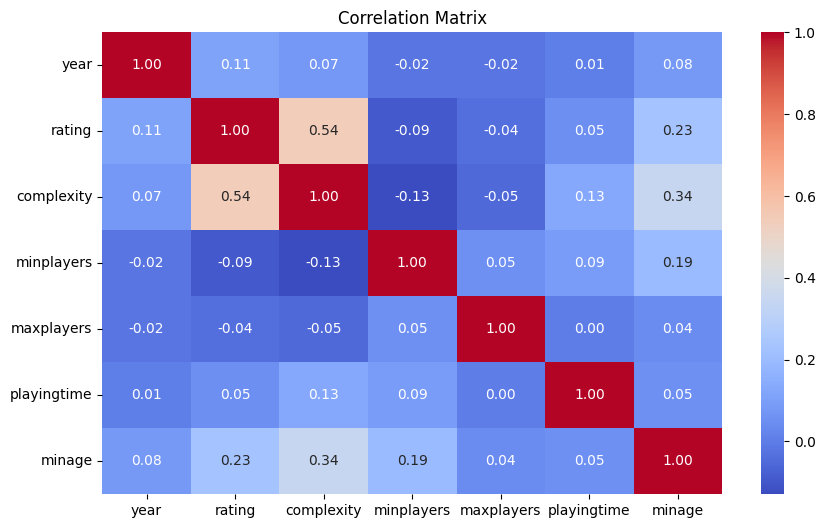

In [11]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
corr_matrix = games[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

We can observe that most of them are uncorrelated. The only variables that are quite positively correlated are complexity with rating, which makes sense.

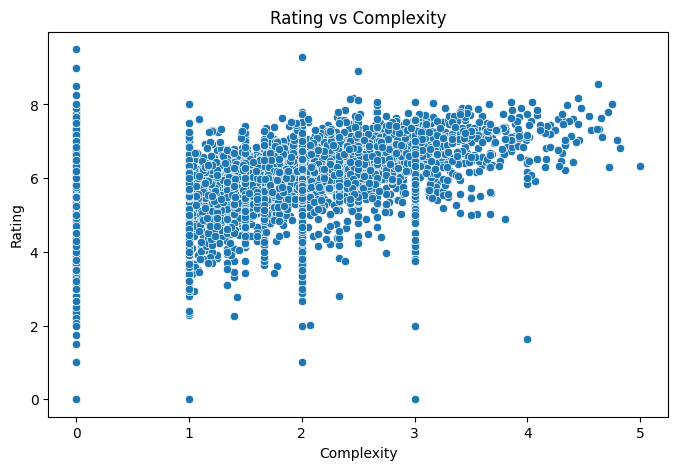

In [12]:
# Boxplot of rating vs complexity
plt.figure(figsize=(8, 5))
sns.scatterplot(x='complexity', y='rating', data=games)
plt.title("Rating vs Complexity")
plt.xlabel("Complexity")
plt.ylabel("Rating")
plt.show()

Let's explore the length of the descriptions.

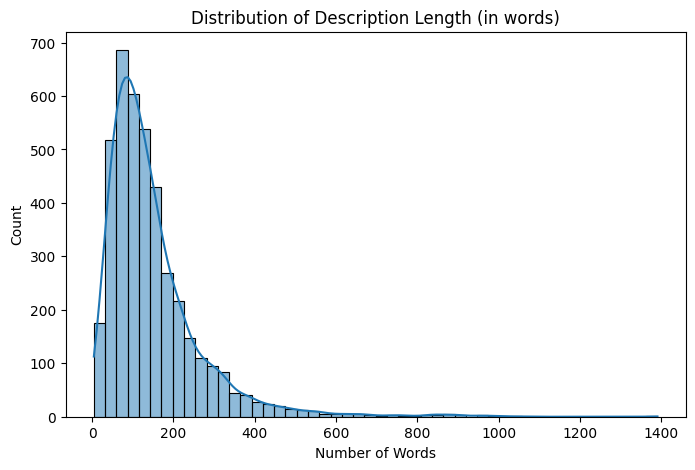

In [13]:
# Description length analysis
games['description_length'] = games['description'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8, 5))
sns.histplot(games['description_length'], bins=50, kde=True)
plt.title("Distribution of Description Length (in words)")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()

Most of the descriptions contain more than 100 words. The mean is 160. This means that the descriptions are very complete and explain fully the board games.


## Task 1: Text Preprocessing and vectorization

### Text Preprocessing

To implement the NLP preprocessing pipeline, we used the Spacy library, with a pretrained model 'en_core_web_sm'.

We define manually some custom stopwords that are common to all games and do not have relevance.

In [14]:
# Load English spaCy model
nlp = spacy.load("en_core_web_sm")

custom_stopwords = {
    "game", "s", "t", "play", 'player', 'move', 'turn', 'win', 'lose', 'score', 'value',
    'collect', 'lose', 'victory', 'try', 'use', 'end', 'set', 'allow',
    'number', 'total', 'get', 'include', 'rule', 'content'
}

def clean_text(text):
    if pd.isna(text):
        return ""

    # Lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)

    # Remove special characters and numbers
    text = re.sub(r"[^a-z\s]", " ", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Apply spaCy NLP processing
    doc = nlp(text)

    # Remove stopwords, lemmatize, exclude punctuations, and custom words
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and token.is_alpha and token.lemma_ not in custom_stopwords
    ]

    return " ".join(tokens)

In [15]:
# Apply the cleaning function to all descriptions
games["clean_description"] = games["description"].apply(clean_text)

In [16]:
# Example: original and cleaned text for first entry
print("Original:\n", games["description"][0])
print("Cleaned:\n", games["clean_description"][0])

Original:
 Die Macher is a game about seven sequential political races in different regions of Germany. Players are in charge of national political parties, and must manage limited resources to help their party to victory. The winning party will have the most victory points after all the regional elections. There are four different ways of scoring victory points. First, each regional election can supply one to eighty victory points, depending on the size of the region and how well your party does in it. Second, if a party wins a regional election and has some media influence in the region, then the party will receive some media-control victory points. Third, each party has a national party membership which will grow as the game progresses and this will supply a fair number of victory points. Lastly, parties score some victory points if their party platform matches the national opinions at the end of the game.&#10;&#10;The 1986 edition featured four parties from the old West Germany and

Now the most common words will be explored. This way we can tune the custom stopwords by adding tokens that are not relevant or that are common for all games and do not add any information as a whole.

In [17]:
# Combine all cleaned descriptions
all_cleaned_text = ' '.join(games['clean_description'].dropna())

# Tokenize the cleaned text
clean_tokens = all_cleaned_text.split()

# Count word frequencies
clean_word_counts = Counter(clean_tokens)

# Get the 30 most common words
most_common_clean_words = clean_word_counts.most_common(30)

print("Most common words in cleaned descriptions:")
for word, count in most_common_clean_words:
    print(f"{word}: {count}")

Most common words in cleaned descriptions:
card: 6914
quot: 5943
board: 2228
point: 1877
piece: 1476
place: 1295
time: 1131
dice: 1088
space: 1082
war: 1058
battle: 1027
roll: 1022
new: 994
color: 943
tile: 925
different: 874
unit: 868
opponent: 865
hand: 844
map: 811
start: 794
counter: 791
base: 776
combat: 759
round: 742
die: 727
edition: 725
high: 690
control: 684
world: 669


Save clean dataset (if desired)

In [18]:
games.to_csv("boardgames_4122_clean.csv", index=False, encoding="utf-8", sep=";")

### Vectorization

#### BoW and TF-IDF

The first two vectorization techniques applied are BoW and TF-IDF. The BoW model represents each of the documents as a sparse vector of word counts. On the other hand,  TF-IDF is the refinement of BoW, which is done by giving a weight to the words based on their term frequency. Words that are very common will be given a small weight, whereas the rare and distinctive words are bound to have a higher weight.

In [19]:
# For this task, we will mainly be working with the column "clean_description".
# We will tokenize this part fist
tokenized_descr = [clean_description.split() for clean_description in games["clean_description"]]

In [20]:
# Then we will create a dictionary and obtain both the BoW corpus and the TF-IDF corpus
# BoW corpus
dictionary = corpora.Dictionary(tokenized_descr)
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_descr]

# TF-IDF corpus
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

Now we would like to obtain some insights from our data using the TF-IDF corpus. However, we cannot use it as it is. `tfidf_corpus`is a sparse corpus matrix, not a dense numpy matrix.

Gensim is optimized for streaming large corpora and if we wanted to do some visualizations, we would need to convert it to dense form.

In [21]:
num_docs = len(tfidf_corpus)
num_terms = len(dictionary)

# Create empty matrix
X_tfidf_gensim = np.zeros((num_docs, num_terms))

# Fill it with TF-IDF scores
for doc_idx, doc in enumerate(tfidf_corpus):
    for term_id, tfidf_score in doc:
        X_tfidf_gensim[doc_idx, term_id] = tfidf_score

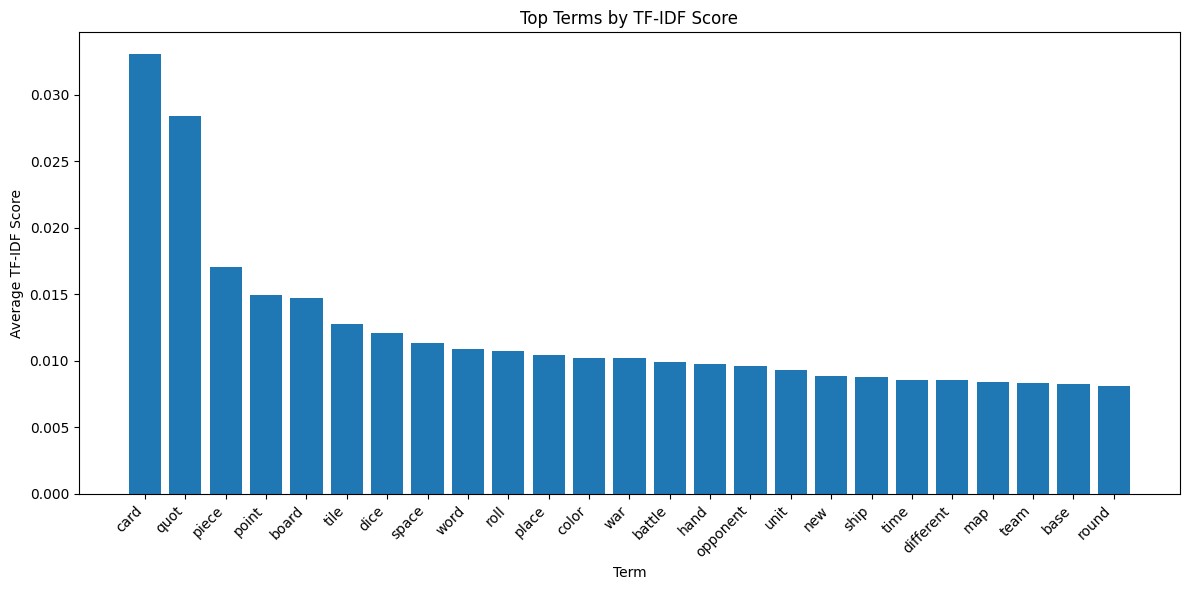

In [22]:
# Compute average TF-IDF per term
avg_tfidf_scores = X_tfidf_gensim.mean(axis=0)

# Top-N terms
top_n = 25
top_term_indices = avg_tfidf_scores.argsort()[::-1][:top_n]

# Get corresponding terms
terms = [dictionary[i] for i in top_term_indices]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(top_n), avg_tfidf_scores[top_term_indices], tick_label=terms)
plt.xlabel('Term')
plt.ylabel('Average TF-IDF Score')
plt.title('Top Terms by TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

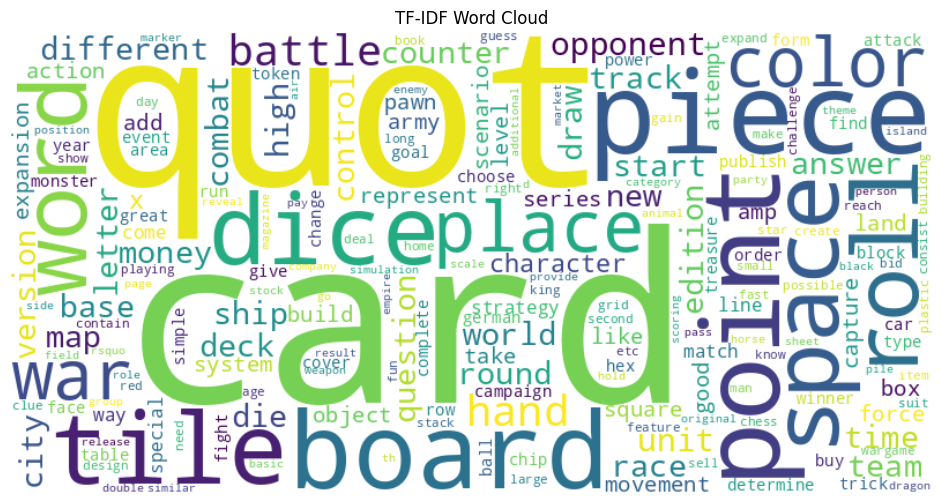

In [23]:
# Total TF-IDF score per term across all documents
tfidf_term_scores = X_tfidf_gensim.sum(axis=0)

# Map term to score
word_freq = {dictionary[i]: tfidf_term_scores[i] for i in range(num_terms)}

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate_from_frequencies(word_freq)

# Display
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('TF-IDF Word Cloud')
plt.show()

As observed in both the top words histogram and the word cloud, most of the high ranked words are highly related to board games. However, words that are common appear with a high ranking, such as card, piece, point. Those words are relevant because not all games strictly have them but they are common, which means that they should not have such high score.

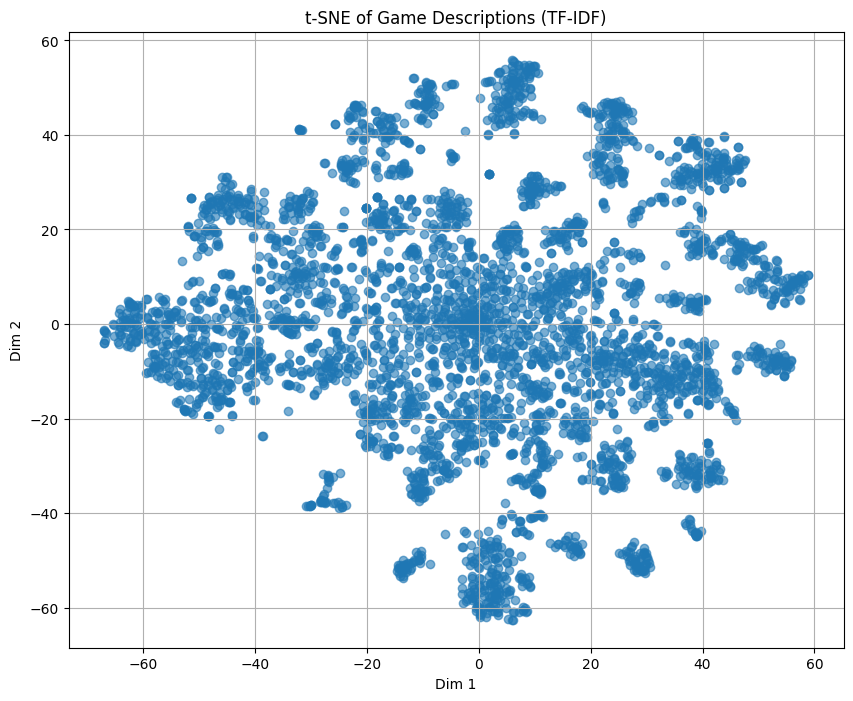

In [24]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Dimensionality reduction
X_reduced = PCA(n_components=50).fit_transform(X_tfidf_gensim)
X_embedded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_reduced)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.6)
plt.title("t-SNE of Game Descriptions (TF-IDF)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

We can observe most of the games clustered in the center of the graph, which means that most games have similar descriptions. Hoewever, some tiny clusters can be observed in the surroundings, which can represent similar games in theme or rules.

#### GloVe Embeddings

GloVe is an unsupervised learning algorithm used to obtain word embeddings by factorizing a word co-occurrence matrix. This embedding approach captures semantic relationships between words by co-occurrence, which means how often the words appear together. We have implemented 2 pretrained model, the one with dimension 100 and another with dimension 300. However, due to the complexity of the descriptions, we decided to use dimension 300 to have a bigger representation and capture better semantic meaning.


In [25]:
def load_glove_embeddings(filepath="glove.6B.300d.txt"):
    embeddings = {}
    with open(filepath, "r", encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

def get_glove_vector(text, glove, dim=300):
    words = text.split()
    vectors = [glove[word] for word in words if word in glove]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

# Load the 100-dimensional GloVe embeddings
glove = load_glove_embeddings("glove.6B.100d.txt")

# Apply GloVe embeddings to each game's description
games["glove_vector100"] = games["clean_description"].apply(lambda x: get_glove_vector(x, glove, dim=100))

# Load the 300-dimensional GloVe embeddings
glove = load_glove_embeddings("glove.6B.300d.txt")

# Apply GloVe embeddings to each game's description
games["glove_vector"] = games["clean_description"].apply(lambda x: get_glove_vector(x, glove, dim=300))

print(games["glove_vector"].head())

0    [-0.09122904, 0.073253326, 0.029837092, -0.210...
1    [0.0054334076, 0.1591402, -0.09049598, -0.0551...
2    [-0.05378176, 0.0016613593, 0.08275267, -0.190...
3    [-0.13010518, 0.06962608, -0.14862925, -0.1488...
4    [-0.04820624, 0.026263943, -0.07223329, -0.149...
Name: glove_vector, dtype: object


In [26]:
len(games["glove_vector100"][0]), len(games["glove_vector"][0])

(100, 300)

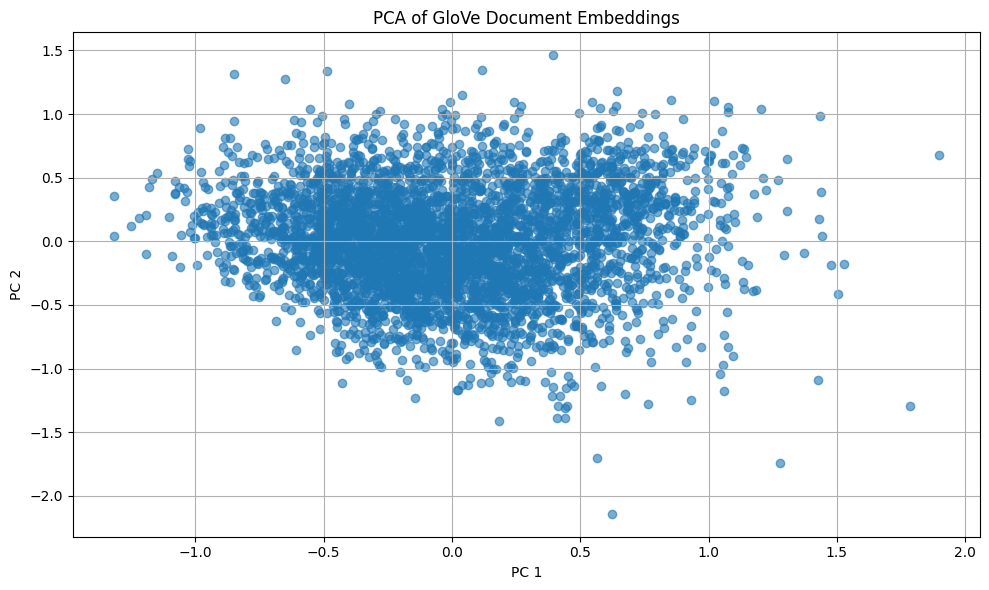

Explained Variance (first 2 components): 23.05%


In [28]:
# Reduce GloVe (100ver) to 2D with PCA
pca = PCA(n_components=2)
X_glove100 = np.vstack(games["glove_vector100"].values)
X_glove_pca100 = pca.fit_transform(X_glove100)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_glove_pca100[:, 0], X_glove_pca100[:, 1], alpha=0.6)
plt.title("PCA of GloVe Document Embeddings")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# How much variance PCA retained
explained_var = pca.explained_variance_ratio_.sum()
print(f"Explained Variance (first 2 components): {explained_var:.2%}")

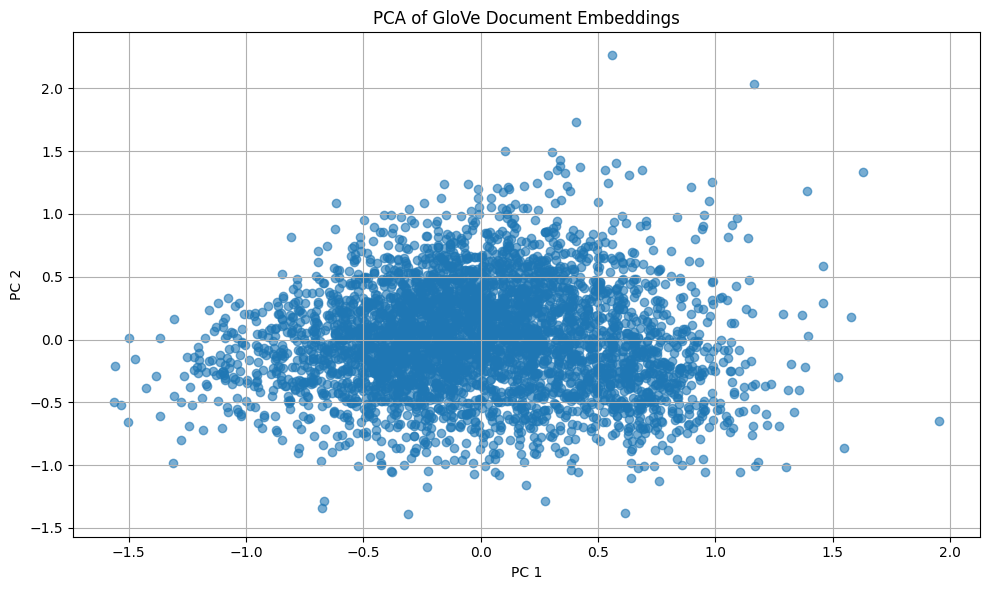

Explained Variance (first 2 components): 17.65%


In [29]:
# Reduce GloVe (300ver) to 2D with PCA
pca = PCA(n_components=2)
X_glove = np.vstack(games["glove_vector"].values)
X_glove_pca = pca.fit_transform(X_glove)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_glove_pca[:, 0], X_glove_pca[:, 1], alpha=0.6)
plt.title("PCA of GloVe Document Embeddings")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# How much variance PCA retained
explained_var = pca.explained_variance_ratio_.sum()
print(f"Explained Variance (first 2 components): {explained_var:.2%}")

The previous plot represents that the embeddings of the descriptions are quite similar, because they are close together. No clear clusters can be identified in the embeddings

#### Doc2Vec Embeddings

Doc2Vec is actually an extension of Word2Vec, which also generates word embeddings. It is designed to generate vector representations of whole documents or sentences.

Opposite to Word2Vec, which is implemented to learn embeddings for individual words, Doc2Vec assigns a unique vector to each document apart from learning word embeddings. The model then captures semantic meaning at the document level by training on both contexts, word and document.



In [34]:
# Prepare data
documents = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(games["clean_description"])]

# Train
doc2vec_model = Doc2Vec(documents, vector_size=300, window=5, min_count=2, workers=4, epochs=40)

# Vectorize
X_doc2vec = np.array([doc2vec_model.dv[str(i)] for i in range(len(documents))])

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


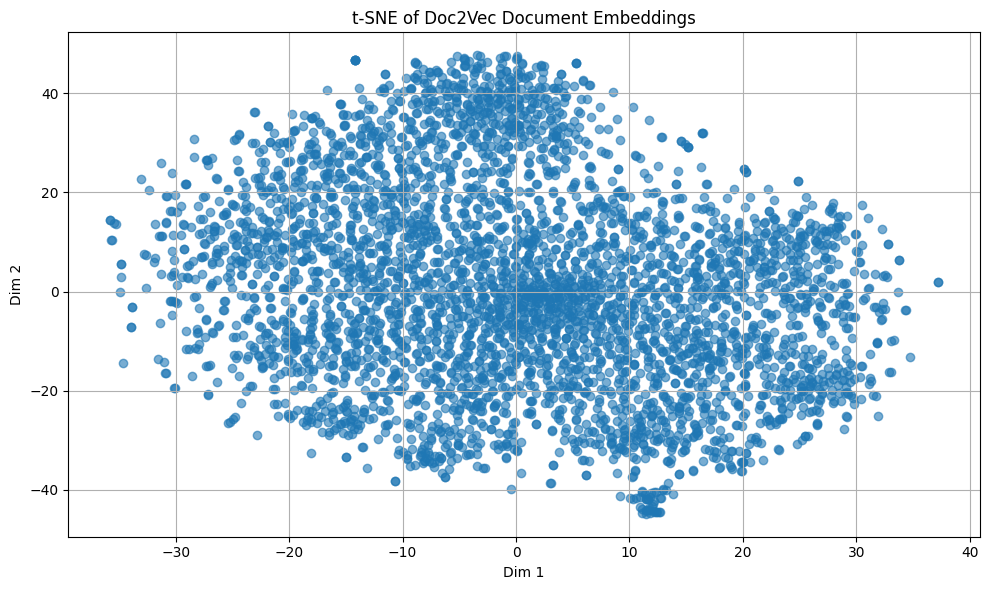

In [35]:
# Run t-SNE on doc2vec vectors
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
X_doc2vec_tsne = tsne.fit_transform(X_doc2vec)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_doc2vec_tsne[:, 0], X_doc2vec_tsne[:, 1], alpha=0.6)
plt.title("t-SNE of Doc2Vec Document Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()

A similar conclusion can be drawn from this second approach, no clusters are observed and most of the points are close together. However, we can observe a bit more of separation between embeddings and some mixtures of distributions could be spotted

#### Similar Games' Comparison

In [41]:
def find_similar_glove_df(target_game, df, vector_column="glove_vector", name_column="name", top_k=5):
    # Get the target row
    target_row = df[df[name_column] == target_game]
    if target_row.empty:
        print(f"Game '{target_game}' not found.")
        return

    target_vec = np.array(target_row.iloc[0][vector_column]).reshape(1, -1)

    similarities = []

    for _, row in df.iterrows():
        other_name = row[name_column]
        if other_name == target_game:
            continue
        other_vec = np.array(row[vector_column]).reshape(1, -1)
        sim = cosine_similarity(target_vec, other_vec)[0][0]
        similarities.append((other_name, sim))

    sorted_games = sorted(similarities, key=lambda x: -x[1])
    for game, sim in sorted_games[:top_k]:
        print(f"{game} (distance={1 - sim:.4f})")

find_similar_glove_df("CATAN", games, top_k=5)

CATAN: Cities & Knights (distance=0.0722)
New England (distance=0.0880)
Targui (distance=0.0899)
Magna Grecia (distance=0.1037)
Space Race (distance=0.1046)


In [45]:
def find_similar_doc2vec_df(target_game, df, model, name_column="name", top_k=5, return_results=False):
    target_idx = df[df[name_column] == target_game].index
    if target_idx.empty:
        print(f"Game '{target_game}' not found.")
        return

    target_idx = target_idx[0]
    target_vec = model.dv[target_idx].reshape(1, -1)

    similarities = []
    for idx, row in df.iterrows():
        if idx == target_idx:
            continue
        other_vec = model.dv[idx].reshape(1, -1)
        sim = cosine_similarity(target_vec, other_vec)[0][0]
        distance = 1 - sim
        similarities.append((row[name_column], distance))

    # Sort by increasing distance
    sorted_games = sorted(similarities, key=lambda x: x[1])

    print(f"\nSimilar games to '{target_game}' using Doc2Vec:")
    for game, dist in sorted_games[:top_k]:
        print(f"{game} (distance={dist:.4f})")

    if return_results:
        return sorted_games[:top_k]

find_similar_doc2vec_df("CATAN", games, doc2vec_model, top_k=5)


Similar games to 'CATAN' using Doc2Vec:
New England (distance=0.3499)
CATAN: Cities & Knights (distance=0.3579)
Die Magier von Pangea (distance=0.3889)
Elfenroads (distance=0.4065)
Magna Grecia (distance=0.4162)


#### LDA

Latent Dirichlet Allocation (LDA) is a generative probabilistic model which is used for topic modeling and discovering abstract topics within the collection of documents presented, the descriptions of the games.

In [32]:
corpus = games['clean_description'].tolist()

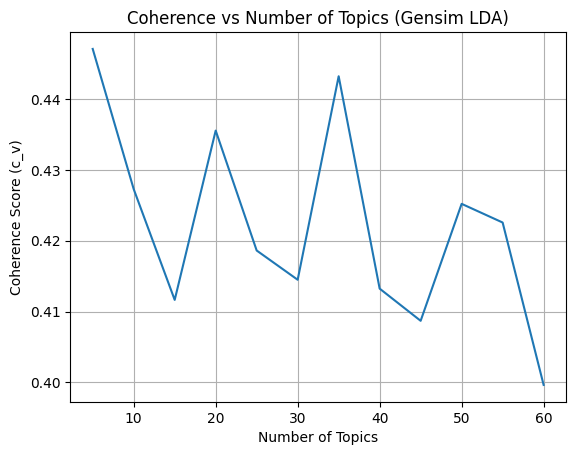

In [47]:
# Try different numbers of topics
coherence_scores = []
models = []
for k in range(5, 61, 5):
    model = LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=k, passes=15, random_state=42)
    coherence = CoherenceModel(model=model, texts=tokenized_descr, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_scores.append(coherence)
    models.append(model)

# Plot coherence vs. topic count
plt.plot(range(5, 61, 5), coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence vs Number of Topics (Gensim LDA)")
plt.grid(True)
plt.show()

# Select best model
best_k = range(5, 61, 5)[np.argmax(coherence_scores)]
best_model = models[np.argmax(coherence_scores)]
best_model.save("lda_best_model.gensim")

In [48]:
for topic_id, words in best_model.show_topics(num_topics=best_k, num_words=10, formatted=False):
    print(f"Topic {topic_id}: {[word for word, prob in words]}")

Topic 0: ['board', 'piece', 'quot', 'dice', 'space', 'roll', 'opponent', 'square', 'color', 'place']
Topic 1: ['island', 'sell', 'buy', 'land', 'different', 'card', 'board', 'market', 'gameboard', 'swimmer']
Topic 2: ['quot', 'word', 'question', 'letter', 'card', 'answer', 'category', 'box', 'version', 'team']
Topic 3: ['quot', 'unit', 'war', 'battle', 'counter', 'scenario', 'point', 'map', 'combat', 'level']
Topic 4: ['card', 'quot', 'hand', 'point', 'round', 'deck', 'tile', 'draw', 'color', 'start']


The beta vector represents the weight of the important words in each topic.

In [49]:
beta_matrix = np.array(best_model.get_topics())
print("Beta shape:", beta_matrix.shape)

Beta shape: (5, 19726)


In [50]:
words = [dictionary[i] for i in range(len(dictionary))]

# We create a dataframe to read the results better
beta_df = pd.DataFrame(beta_matrix, columns=words, index=[f"Topic {i}" for i in range(best_k)])

# Here we display the top words per topic (beta vectors), with the probabilities.
for topic_id in range(best_k):
    print(f"\nTopic {topic_id}:")
    print(beta_df.iloc[topic_id].sort_values(ascending=False).head(10))


Topic 0:
board       0.017151
piece       0.013515
quot        0.013045
dice        0.011171
space       0.007110
roll        0.006987
opponent    0.005868
square      0.005805
color       0.005721
place       0.005617
Name: Topic 0, dtype: float32

Topic 1:
island       0.008787
sell         0.008604
buy          0.007261
land         0.005891
different    0.005631
card         0.005629
board        0.005444
market       0.005133
gameboard    0.004721
swimmer      0.004604
Name: Topic 1, dtype: float32

Topic 2:
quot        0.034033
word        0.017694
question    0.012738
letter      0.010901
card        0.009209
answer      0.008439
category    0.006377
box         0.006349
version     0.005512
team        0.005193
Name: Topic 2, dtype: float32

Topic 3:
quot        0.025950
unit        0.015254
war         0.014844
battle      0.013626
counter     0.011431
scenario    0.010985
point       0.010620
map         0.010437
combat      0.009387
level       0.008698
Name: Topic 3, dtype

In a more compact way:

In [51]:
best_model.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

[(0,
  '0.017*"board" + 0.014*"piece" + 0.013*"quot" + 0.011*"dice" + 0.007*"space" + 0.007*"roll" + 0.006*"opponent" + 0.006*"square" + 0.006*"color" + 0.006*"place"'),
 (1,
  '0.009*"island" + 0.009*"sell" + 0.007*"buy" + 0.006*"land" + 0.006*"different" + 0.006*"card" + 0.005*"board" + 0.005*"market" + 0.005*"gameboard" + 0.005*"swimmer"'),
 (2,
  '0.034*"quot" + 0.018*"word" + 0.013*"question" + 0.011*"letter" + 0.009*"card" + 0.008*"answer" + 0.006*"category" + 0.006*"box" + 0.006*"version" + 0.005*"team"'),
 (3,
  '0.026*"quot" + 0.015*"unit" + 0.015*"war" + 0.014*"battle" + 0.011*"counter" + 0.011*"scenario" + 0.011*"point" + 0.010*"map" + 0.009*"combat" + 0.009*"level"'),
 (4,
  '0.075*"card" + 0.025*"quot" + 0.012*"hand" + 0.009*"point" + 0.008*"round" + 0.008*"deck" + 0.008*"tile" + 0.007*"draw" + 0.007*"color" + 0.007*"start"')]

The theta vectors explain how much of each topic is inside the documents. Note that only the few first topics are relevant, the ones with high weights. Therefore, to avoid computational cost, we opt to take only the most relevant topic.

In [52]:
theta_matrix = []
for doc in bow_corpus:
    doc_topics = best_model.get_document_topics(doc, minimum_probability=0)
    theta_matrix.append([prob for _, prob in doc_topics])

theta_matrix = np.array(theta_matrix)
print("Theta shape:", theta_matrix.shape)

Theta shape: (4122, 5)


In [53]:
# Dataframe for the thetas
theta_df = pd.DataFrame(theta_matrix, columns=[f"Topic {i}" for i in range(best_k)])

# We just display the most relevant topic (the one with the highest probability)
theta_df["Dominant Topic"] = theta_df.idxmax(axis=1)

print(theta_df[["Dominant Topic"]])

     Dominant Topic
0           Topic 2
1           Topic 4
2           Topic 0
3           Topic 0
4           Topic 0
...             ...
4117        Topic 3
4118        Topic 3
4119        Topic 3
4120        Topic 3
4121        Topic 3

[4122 rows x 1 columns]


A very interactive repesentation of the topics can be observed using the pyLDAvis library. Here we can see the diferent topics in a two dimensional graph, showing their relevance across the documents and the words inside them.

In [55]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, bow_corpus, dictionary)
pyLDAvis.save_html(vis, "assets/lda_vis.html")
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.017933  0.053739       1        1  33.678476
4     -0.052125  0.110886       2        1  24.583779
3      0.262878 -0.113636       3        1  20.060076
2     -0.027883  0.141396       4        1  15.192031
1     -0.200803 -0.192384       5        1   6.485638, topic_info=         Term         Freq        Total Category  logprob  loglift
56       card  5999.000000  5999.000000  Default  30.0000  30.0000
82       quot  5929.000000  5929.000000  Default  29.0000  29.0000
1319     word   763.000000   763.000000  Default  28.0000  28.0000
367      unit   868.000000   868.000000  Default  27.0000  27.0000
349       war   847.000000   847.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
56       card   103.559141  5999.645966   Topic5  -5.1798  -1.3237
344      roll    78.479506  1162.518286   Topic5  -5.4571   0.0401
0         add    63.867735   478.211157   Topic5  -5.6632   0.7223
133      ship    62.616179   521.776567   Topic5  -5.6829   0.6154
12    feature    56.357345   365.264746   Topic5  -5.7883   0.8667

[366 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2393      5  0.958425      aboard
1380      1  0.925708    abstract
1380      3  0.072935    abstract
433       1  0.997722  accomplish
653       1  0.658379      action
...     ...       ...         ...
327       4  0.333254       world
327       5  0.066651       world
970       1  0.416015           x
970       2  0.107674           x
970       3  0.474746           x

[664 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 3, 2])

The most relevant topic is 1, since it is the one most documents have as the most coherent.

 ## Sentiment Analysis

In this case, we will be using a zero-shot model from Facebook. We need to be careful when using these models because:

*   They are trained on natural language, not preprocessed or lemmatized text.
*   They expect raw sentences to understand semantic tone.
*   They perform better when given more expressive and emotional content, which can get lost when lemmatizing everything.

Because of this, we need to preprocess again the game descriptions with light preprocessing and use that for using the model that we have selected.

There is an important aspect to consider here, which is that zero-shot classification with large transformer models is computationally expensive and slow when done sequentially.

To optimize performance, we convert our data to a Hugging Face Dataset object, which allows us to apply classification in efficient batches. Batching not only reduces runtime significantly, but also allows the model to process multiple descriptions in parallel without affecting the accuracy of individual predictions.

As a result of the classification process, we introduced two new variables into our dataset: `predicted_emotion` and `predicted_vibe`. The former reflects the emotional or narrative mood of the game (e.g., dark, funny, nostalgic), while the latter characterizes the gameplay dynamics or player experience (e.g., strategic, cooperative, family-friendly).

In [63]:
def light_clean(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"<.*?>", " ", text)       # remove HTML
    text = re.sub(r"\s+", " ", text).strip() # normalize whitespace
    return text

In [64]:
# Load your clean dataframe
games["light_clean_description"] = games["description"].apply(light_clean)
hf_dataset = Dataset.from_pandas(games[["light_clean_description"]])

# Load the zero-shot classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)  # device=0 to use GPU

# Labels
emotional_labels = ["funny", "dark", "happy", "serious", "nostalgic", "intense"]
vibe_labels = ["strategic", "cooperative", "competitive", "family-friendly", "chaotic", "educational"]

# Batched classification function
def classify_batch(batch):
    texts = batch["light_clean_description"]

    # Predict emotions and vibes together
    emotion_results = classifier(texts, emotional_labels, batch_size=8)
    vibe_results = classifier(texts, vibe_labels, batch_size=8)

    # If input is batched, results will be a list of dicts
    predicted_emotion = [result["labels"][0] for result in emotion_results]
    predicted_vibe = [result["labels"][0] for result in vibe_results]

    return {
        "predicted_emotion": predicted_emotion,
        "predicted_vibe": predicted_vibe
    }

Device set to use cuda:0


In [66]:
# Apply with batching
hf_dataset = hf_dataset.map(classify_batch, batched=True, batch_size=8)

# Convert back to pandas
games["predicted_emotion"] = hf_dataset["predicted_emotion"]
games["predicted_vibe"] = hf_dataset["predicted_vibe"]

Map:   0%|          | 0/4122 [00:00<?, ? examples/s]

In [67]:
games.drop(columns=['light_clean_description'], inplace=True)

In [68]:
games.to_csv("boardgames_4122_clean_glove_dual_tone.csv", sep=";", index=False)

In [69]:
num_examples = 100

for i in range(num_examples):
    name = games.iloc[i]["name"]
    description = games.iloc[i]["description"][:500]
    emotion = games.iloc[i]["predicted_emotion"]
    vibe = games.iloc[i]["predicted_vibe"]

    print(f"Game: {name}")
    print(f"Description:\n{description}...")
    print(f"Predicted Emotion: {emotion}")
    print(f"Predicted Vibe: {vibe}\n")

Game: Die Macher
Description:
Die Macher is a game about seven sequential political races in different regions of Germany. Players are in charge of national political parties, and must manage limited resources to help their party to victory. The winning party will have the most victory points after all the regional elections. There are four different ways of scoring victory points. First, each regional election can supply one to eighty victory points, depending on the size of the region and how well your party does in it. Se...
Predicted Emotion: intense
Predicted Vibe: competitive

Game: Dragonmaster
Description:
Dragonmaster is a trick-taking card game based on an older game called Coup d'&#195;&#137;tat. Each player is given a supply of plastic gems, which represent points. Each player will get to be the dealer for five different hands, with slightly different goals for each hand. After all cards have been dealt out, the dealer decides which hand best suits his or her current cards,

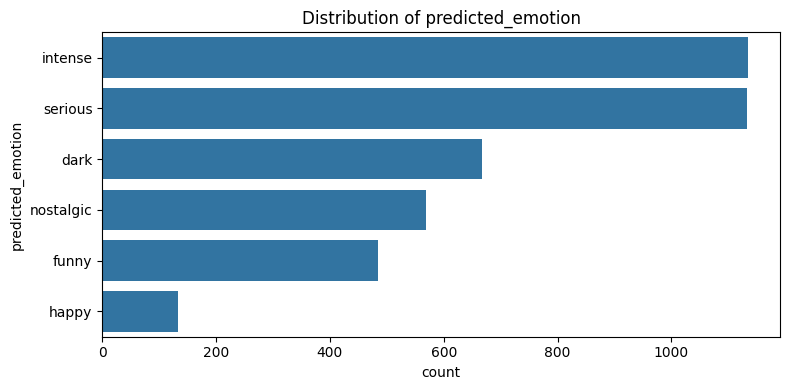

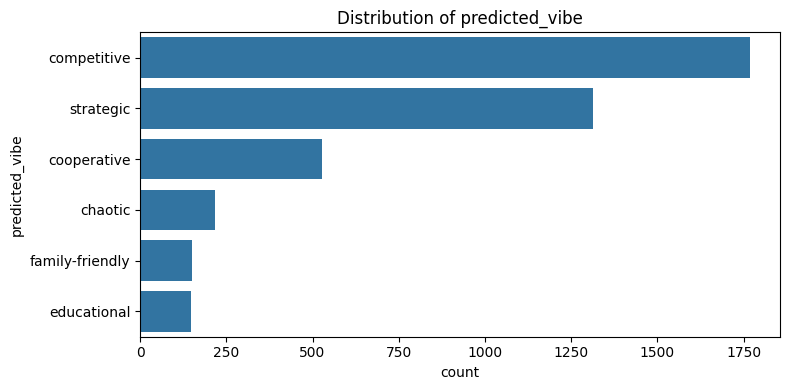

In [70]:
for col in ["predicted_emotion", "predicted_vibe"]:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=games, y=col, order=games[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

## Task 2: Machine Learning (Recommender System)

#### Load dataset and reviews

Loading again the games dataset with all the processes included in Task 1.

In [ ]:
filename = "boardgames_4122_clean_glove_dual_tone.csv"
games = pd.read_csv(filename, sep=";")
games

,id,name,description,year,rating,complexity,minplayers,maxplayers,playingtime,minage,...,clean_description,predicted_emotion,predicted_vibe,glove_vector,tsne_1,tsne_2,description_cluster20,avg_rating,num_ratings,popularity_score
0,1,Die Macher,Die Macher is a game about seven sequential po...,1986,7.58777,4.3081,3,5,240,14,...,die macher seven sequential political race dif...,serious,competitive,[-3.08733493e-01 3.24046969e-01 1.91316932e-...,13.456710,28.006823,18,7.585922,5865.0,7.573010
1,2,Dragonmaster,Dragonmaster is a trick-taking card game based...,1981,6.66468,1.9643,3,4,30,12,...,dragonmaster trick taking card base old call c...,intense,chaotic,[-1.26252010e-01 1.75697044e-01 1.94115594e-...,-32.615550,-0.613356,2,6.653583,601.0,6.544687
2,3,Samurai,Samurai is set in medieval Japan. Players comp...,1998,7.47596,2.4420,2,4,60,10,...,samurai set medieval japan compete gain favor ...,intense,competitive,[-1.49731815e-01 2.95220733e-01 9.80601683e-...,14.464891,2.472592,15,7.472430,16574.0,7.467924
3,4,Tal der Könige,When you see the triangular box and the luxuri...,1992,6.61540,2.6875,2,4,60,12,...,triangular box luxurious large block tal der k...,happy,competitive,[-9.35205147e-02 2.23712847e-01 -1.03773594e-...,4.330486,-21.912030,11,6.609387,358.0,6.429784
4,5,Acquire,"In Acquire, each player strategically invests ...",1964,7.35053,2.4923,2,6,90,12,...,acquire strategically invest business try reta...,serious,strategic,[-6.18437678e-02 2.30222315e-01 9.56441462e-...,-18.765612,-0.012297,14,7.398392,20814.0,7.394839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,2992,Rythmo,2-player abstract based on a medieval game cal...,1985,5.50000,3.5000,2,2,30,0,...,abstract base medieval call rithmomachy long c...,intense,chaotic,[-0.33392113 0.41472754 0.02700007 0.213864...,-3.791342,-24.915041,4,NaN,NaN,NaN
1779,2994,Guderian's Blitzkrieg: The Drive on Moscow,"Guderian's Blitzkrieg - The Drive on Moscow, S...",1992,7.03520,3.8667,2,2,360,12,...,guderian blitzkrieg drive moscow september dec...,intense,educational,[-2.60823131e-01 1.32168651e-01 1.66197613e-...,26.259657,17.899445,19,7.021895,153.0,6.591104
1780,2996,Dodge City,Directly from the rules:&#10;&#10;The board sh...,1983,5.57179,2.3333,2,5,60,8,...,directly show western town dodge city fight do...,serious,competitive,[ 1.04383901e-02 1.98655725e-01 2.01404706e-...,-3.596778,16.433620,7,5.571795,39.0,4.434694
1781,2998,Reds! The Russian Civil War 1918-1921,Reds! The Russian Civil War 1918-1921 is a two...,2001,7.29145,3.0789,1,2,360,12,...,red russian civil war wargame cover dramatic e...,intense,chaotic,[-0.22765921 0.17675424 0.04304298 0.047910...,27.720398,20.772121,19,7.295847,559.0,7.167625


We also load the reviews dataset. This dataset contains more than 1,8 million reviews from users that have played the games. The rating is numeric in a range from 1 to 10.

In [ ]:
filename = "reviews.csv"
reviews = pd.read_csv(filename, sep=",")
reviews

,Unnamed: 0,user,rating,comment,ID,name
0,0,sidehacker,10.0,NaN,13,CATAN
1,1,Varthlokkur,10.0,NaN,13,CATAN
2,2,dougthonus,10.0,"Currently, this sits on my list as my favorite...",13,CATAN
3,3,cypar7,10.0,"I know it says how many plays, but many, many ...",13,CATAN
4,4,ssmooth,10.0,NaN,13,CATAN
...,...,...,...,...,...,...
1872435,26199316,Pyrogal,1.0,Total garbage. This game looks like it was a ...,1546,Worlds of Heroes & Tyrants
1872436,26199317,jbuergel,1.0,This might be the biggest ripoff I've ever bee...,1546,Worlds of Heroes & Tyrants
1872437,26199318,feztacular1,1.0,This game is a turd. Pure and simple.,1546,Worlds of Heroes & Tyrants
1872438,26199319,balsak40,1.0,"Awful, just awful.",1546,Worlds of Heroes & Tyrants


#### Games Similarity Exploration

We will reuse the GloVe embeddings done in Task 1. Once we had vector representations of all our games, we computed the cosine similarity between every pair of games so see how closely aligned vectors are.

Furthermore, we proceeded by displaying a histogram that plots the distribution of the similarity values. This might be useful because it can help us understand:

*   Are most games very similar?
*   Do we have a wide range of similarity?


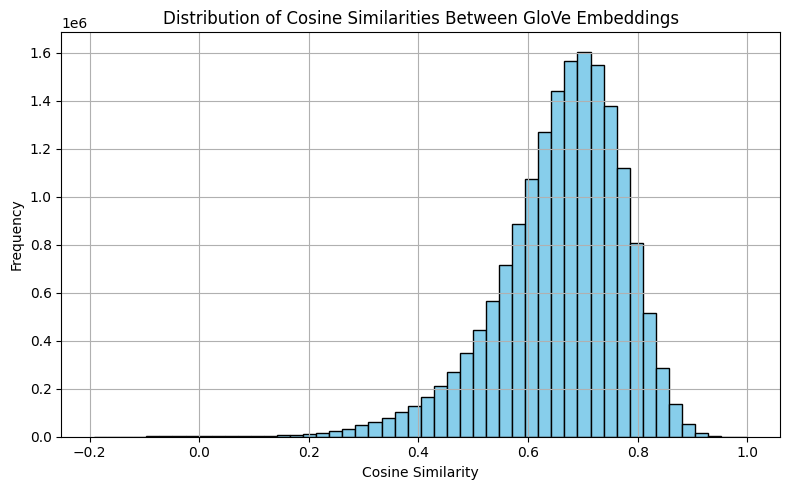

In [74]:
glove_vectors = np.vstack(games["glove_vector"].values)

# Compute the full cosine similarity matrix
sim_matrix = cosine_similarity(glove_vectors)

# Remove diagonal values (self-similarity)
np.fill_diagonal(sim_matrix, np.nan)

# Flatten and filter out NaNs
similarities = sim_matrix[~np.isnan(sim_matrix)]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(similarities, bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Cosine Similarities Between GloVe Embeddings")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

From this histogram, we can learn different things, some along the lines of:

1.   Most pair have high similarity scores, grouped between 0.7 and 0.8, which may be telling us that many game descriptions are using similar language or concepts.
2.   Very few pairs are below 0.6, transalting into strong dissimilarities in descriptions being rare.

These results can be interpreted in different ways, because if we were show that there is a semantic consistency, these results would confirm it.

However, if our goal is to detect meaningful clusters or differentiate games precisely, since everything is mostly 85%-95% similar, we are not getting much variation.

Because of this, we will try and enhance GloVe by trying a contextual embedding such as BERT and combining text with some more metadata.

As of right now, let's take a deeper look to our embeddings.


In [ ]:
def get_min_max_similarity(games_df):
    # Stack GloVe vectors into a 2D array
    vectors = np.vstack(games_df["glove_vector"].values)

    # Compute full cosine similarity matrix
    sim_matrix = cosine_similarity(vectors)

    # Remove diagonal (similarity with self = 1.0)
    np.fill_diagonal(sim_matrix, np.nan)

    # Get min and max ignoring NaNs
    min_sim = np.nanmin(sim_matrix)
    max_sim = np.nanmax(sim_matrix)
    mean_sim = np.nanmean(sim_matrix)

    return min_sim, max_sim, mean_sim

In [ ]:
min_similarity, max_similarity, mean = get_min_max_similarity(games)
print(f"Min similarity: {min_similarity:.4f}, Max similarity: {max_similarity:.4f}")
print(mean)

In [ ]:
def get_min_max_similarity_with_ids(games_df):
    # Stack GloVe vectors into a 2D array
    vectors = np.vstack(games_df["glove_vector"].values)

    # Compute full cosine similarity matrix
    sim_matrix = cosine_similarity(vectors)

    # Remove diagonal (self-similarity)
    np.fill_diagonal(sim_matrix, np.nan)

    # Get min, max, and mean ignoring NaNs
    min_sim = np.nanmin(sim_matrix)
    max_sim = np.nanmax(sim_matrix)
    mean_sim = np.nanmean(sim_matrix)

    # Get indices of min and max
    min_indices = np.unravel_index(np.nanargmin(sim_matrix), sim_matrix.shape)
    max_indices = np.unravel_index(np.nanargmax(sim_matrix), sim_matrix.shape)

    # Get IDs and names
    min_pair = (games_df.iloc[min_indices[0]]["id"], games_df.iloc[min_indices[1]]["id"])
    max_pair = (games_df.iloc[max_indices[0]]["id"], games_df.iloc[max_indices[1]]["id"])

    return min_sim, max_sim, mean_sim, min_pair, max_pair

In [ ]:
min_sim, max_sim, mean_sim, min_pair, max_pair = get_min_max_similarity_with_ids(games)
print(f"Min similarity: {min_sim:.4f} between games {min_pair}")
print(f"Max similarity: {max_sim:.4f} between games {max_pair}")
print(f"Mean similarity: {mean_sim:.4f}")

min_names = (games[games["id"] == min_pair[0]]["name"].values[0],
             games[games["id"] == min_pair[1]]["name"].values[0])
max_names = (games[games["id"] == max_pair[0]]["name"].values[0],
             games[games["id"] == max_pair[1]]["name"].values[0])
print(f"Min similarity between: {min_names}")
print(f"Max similarity between: {max_names}")

Min similarity: 0.1811 between games (2286, 2473)
Max similarity: 0.9992 between games (712, 2288)
Mean similarity: 0.8323
Min similarity between: ('Blood Bowl Star Players', 'Winkeladvokat')
Max similarity between: ('Blood Bowl (Third Edition)', 'Blood Bowl (Second Edition)')


Here we see the games with the least similarity. In these games, the description is highly uninformative.

In [ ]:
print(games[games['id'] == 2286]['clean_description'].values[0])
print(games[games['id'] == 2473]['clean_description'].values[0])

expand new change creation new star simple campaign skill new race background description af famous team star card blood bowl second microbadge blood bowl fan blood bowl fan blood bowl fan blood bowl fan human blood bowl fan norse blood bowl team manager card fan blood bowl fan chaos dwarve blood bowl fan orcs amp goblins blood bowl fan chaos blood bowl fan amazon blood bowl fan halfling blood bowl fan vampire blood bowl fan dwarve blood bowl fan dark elve blood bowl fan skaven blood bowl fan elve blood bowl fan wood elve blood bowl fan lizardman blood bowl fan undead expand blood bowl second
winkeladvokat abstract implement cabale


##### GloVe + Metadata

Now that we have explored similarity using only text (via GloVe), we can try and add  metadata features to enrich our similarity analysis.

We selected some additional features that might influence how games relate to each other, such as the number of players, game complexity...

In [75]:
extra_features = ["year", "rating", "complexity", "minplayers", "maxplayers", "playingtime", "minage"]

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform
games_scaled_features = scaler.fit_transform(games[extra_features])

# Save them into a new column
games["extra_vector"] = list(games_scaled_features)

In [76]:
# Now we combine the textual (GloVe) vector and the extra features into a single vector.
# Each game is now represented by a vector that includes both semantic and numeric information.
games["combined_vector"] = games.apply(
    lambda row: np.concatenate([row["glove_vector"], row["extra_vector"]]),
    axis=1)

In [77]:
len(games['combined_vector'][0])

307

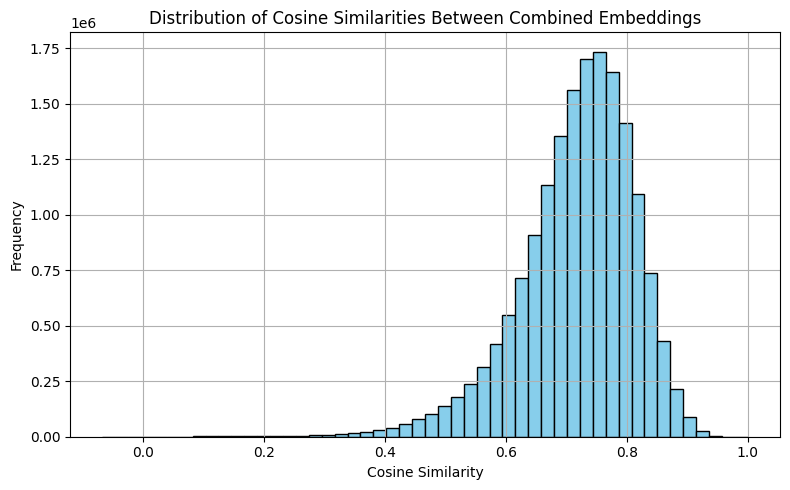

In [78]:
combined_vectors = np.vstack(games["combined_vector"].values)

# Compute the full cosine similarity matrix
sim_matrix = cosine_similarity(combined_vectors)

# Remove diagonal values (self-similarity)
np.fill_diagonal(sim_matrix, np.nan)

# Flatten and filter out NaNs
similarities = sim_matrix[~np.isnan(sim_matrix)]

plt.figure(figsize=(8, 5))
plt.hist(similarities, bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Cosine Similarities Between Combined Embeddings")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

When comparing the similarity histograms, we find that using GloVe alone provides a broader range of similarity scores between games. It captures meaningful differences in game descriptions, making it more effective for differentiating games.

Aadding extra features like year, rating, and player count reduces variability in similarity scores, making most games to appear overly similar. This limits the model's ability to differentiate between games, making the combined approach less useful in our context.

In [ ]:
games[games['name']== 'Siesta']

In [ ]:
games[games['name']== 'CATAN']

In [ ]:
def compare_games_combined_similarity(game_id_1, game_id_2, games_df):
    # Get combined vectors
    vec1 = games_df.loc[games_df["id"] == game_id_1, "combined_vector"].values[0]
    vec2 = games_df.loc[games_df["id"] == game_id_2, "combined_vector"].values[0]

    # Get descriptions
    desc1 = games_df.loc[games_df["id"] == game_id_1, "clean_description"].values[0]
    desc2 = games_df.loc[games_df["id"] == game_id_2, "clean_description"].values[0]

    # Compute cosine similarity
    sim = cosine_similarity([vec1], [vec2])[0][0]

    # Print the results
    print(f"Cosine similarity between Game {game_id_1} and Game {game_id_2}: {sim:.4f}")
    print(f"\nDescription of Game {game_id_1}: {desc1}")
    print(f"\nDescription of Game {game_id_2}: {desc2}")

In [ ]:
# Example usage
compare_games_combined_similarity(game_id_1=171, game_id_2=13, games_df=games)

##### BERT

Finally, we explore BERT to represent each game's description. Unlike GloVe, which uses static word vectors, BERT captures contextual meaning, allowing us to better differentiate between similar words used in different contexts.



In [79]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()  # Set model to evaluation mode

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

We have defined a function that takes in a game description and returns a 768-dimensional embedding representing the entire sentence. We do this by extracting the embedding of the special CLS token, which BERT is trained to use as a summary of the sentence.

In [80]:
def get_bert_embeddings(texts, tokenizer, model, batch_size=16, device="cpu"):
    model.to(device)
    model.eval()
    embeddings = []

    dataloader = DataLoader(texts, batch_size=batch_size)

    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # shape: (batch_size, 768)
            embeddings.extend(cls_embeddings.cpu().numpy())

    return embeddings

In [81]:
texts = games["clean_description"].tolist()
bert_vectors = get_bert_embeddings(texts, tokenizer, model, batch_size=16, device="cuda" if torch.cuda.is_available() else "cpu")
games["bert_vector"] = bert_vectors

100%|██████████| 258/258 [00:33<00:00,  7.75it/s]


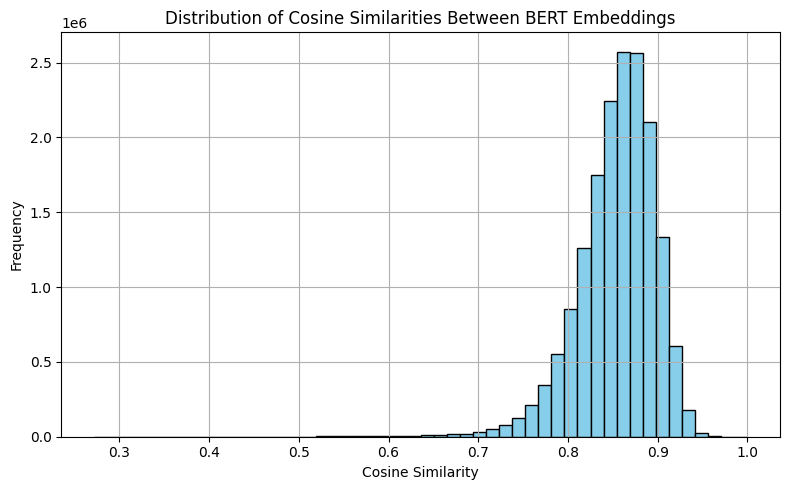

In [82]:
bert_vectors = np.vstack(games["bert_vector"].values)

# Compute the full cosine similarity matrix
sim_matrix = cosine_similarity(bert_vectors)

# Remove diagonal values (self-similarity)
np.fill_diagonal(sim_matrix, np.nan)

# Flatten and filter out NaNs
similarities = sim_matrix[~np.isnan(sim_matrix)]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(similarities, bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Cosine Similarities Between BERT Embeddings")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

The histogram of cosine similarities using BERT shows a broader and more informative distribution than GloVe or GloVe+features.

Similarities range from 0.60 to 0.96, with a peak around 0.90, indicating that BERT captures contextual differences between game descriptions more effectively.


#### Reviews Dataset Exploration

Now we explore the dataset of user reviews to understand how many games have been reviewed, the distribution of ratings, and user activity.

In [ ]:
# Basic overview
print("First 5 rows:")
print(reviews.head())

print("\nInfo:")
print(reviews.info())

First 5 rows:
   Unnamed: 0         user  rating  \
0           0   sidehacker    10.0   
1           1  Varthlokkur    10.0   
2           2   dougthonus    10.0   
3           3       cypar7    10.0   
4           4      ssmooth    10.0   

                                             comment  ID   name  
0                                                NaN  13  CATAN  
1                                                NaN  13  CATAN  
2  Currently, this sits on my list as my favorite...  13  CATAN  
3  I know it says how many plays, but many, many ...  13  CATAN  
4                                                NaN  13  CATAN  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1872440 entries, 0 to 1872439
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   user        object 
 2   rating      float64
 3   comment     object 
 4   ID          int64  
 5   name        object 
dtypes: float64(1), int64(2), object(3)
me

In [ ]:
print("\nSummary statistics:")
print(reviews.describe(include='all'))


Summary statistics:
          Unnamed: 0            user        rating comment            ID  \
count   1.872440e+06         1872418  1.872440e+06  392861  1.872440e+06   
unique           NaN          272602           NaN  370335           NaN   
top              NaN  oldgoat3769967           NaN                   NaN   
freq             NaN             828           NaN     539           NaN   
mean    1.132269e+07             NaN  6.831342e+00     NaN  5.107972e+02   
std     7.443265e+06             NaN  1.578301e+00     NaN  5.241667e+02   
min     0.000000e+00             NaN  1.401300e-45     NaN  1.000000e+00   
25%     4.464027e+06             NaN  6.000000e+00     NaN  5.100000e+01   
50%     1.089006e+07             NaN  7.000000e+00     NaN  3.200000e+02   
75%     1.744820e+07             NaN  8.000000e+00     NaN  8.220000e+02   
max     2.619932e+07             NaN  1.000000e+01     NaN  2.119000e+03   

           name  
count   1872440  
unique      990  
top       CA

In [ ]:
# Check for missing values
print("\nMissing values:")
print(reviews.isnull().sum())


Missing values:
Unnamed: 0          0
user               22
rating              0
comment       1479579
ID                  0
name                0
dtype: int64


In [ ]:
# Ratings distribution
plt.figure(figsize=(8, 5))
sns.histplot(reviews['rating'], bins=10)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'reviews' is not defined

<Figure size 800x500 with 0 Axes>

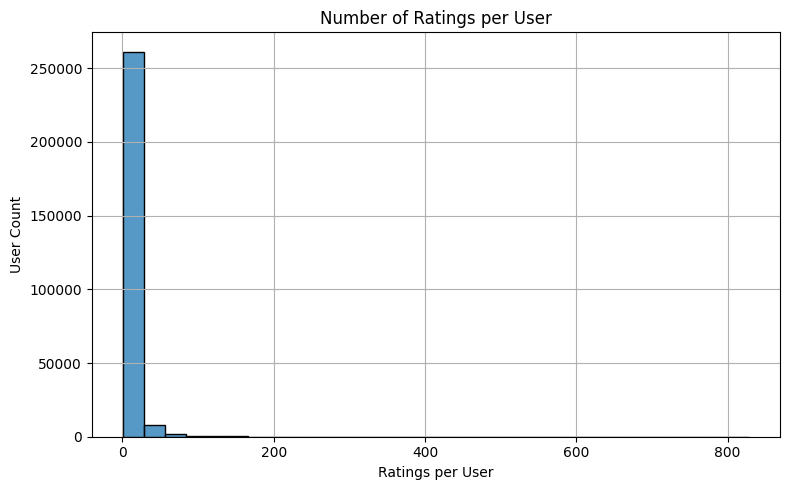

In [ ]:
# Number of ratings per user
ratings_per_user = reviews.groupby("user")["rating"].count()
plt.figure(figsize=(8, 5))
sns.histplot(ratings_per_user, bins=30)
plt.title("Number of Ratings per User")
plt.xlabel("Ratings per User")
plt.ylabel("User Count")
plt.grid(True)
plt.tight_layout()
plt.show()

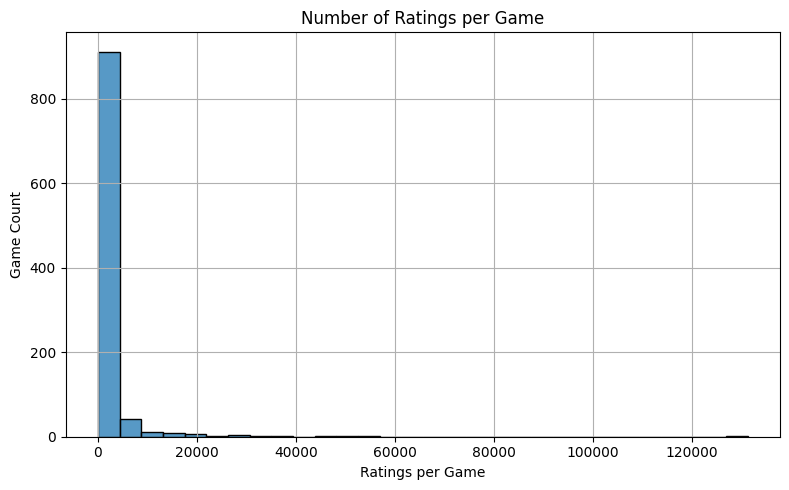

In [ ]:
# Number of ratings per game
ratings_per_game = reviews.groupby("ID")["rating"].count()
plt.figure(figsize=(8, 5))
sns.histplot(ratings_per_game, bins=30)
plt.title("Number of Ratings per Game")
plt.xlabel("Ratings per Game")
plt.ylabel("Game Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Most rated games
top_games = reviews["name"].value_counts().head(10)
print("\nTop 10 most rated games:")
print(top_games)


Top 10 most rated games:
name
CATAN          131303
Carcassonne    131205
Citadels        55610
Bohnanza        48292
Lost Cities     48068
Chess           37913
Risk            36796
Scrabble        33459
For Sale        32173
El Grande       30393
Name: count, dtype: int64


In [ ]:
# Unique game names in the reviews
unique_names = reviews["name"].unique()
print(len(unique_names))

In [ ]:
# Unique reviews of games in the reviews
reviewed_ids = reviews["ID"].unique()

In [ ]:
# Find games with and without reviews
games_with_reviews = games[games["id"].isin(reviewed_ids)]
games_without_reviews = games[~games["id"].isin(reviewed_ids)]

In [ ]:
print(f"Total games: {len(games)}")
print(f"Games with reviews: {len(games_with_reviews)}")
print(f"Games without reviews: {len(games_without_reviews)}")

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=reviews, x='rating', bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Number of Ratings", fontsize=14)
plt.title("Distribution of Game Ratings", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

This histogram shows the frequency of ratings given to games, on a scale from 0 to 10.

The distribution is right-skewed, meaning most ratings are above 6. Also, the most common rating is between 7 and 8, suggesting that users tend to rate games positively, and very low ratings are rare.

In [ ]:
Nrating_por_user = reviews.user.value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(Nrating_por_user, bins=range(1, 21), color='skyblue', edgecolor='black')
plt.xlim(1, 20)
plt.ylim(1, 60000)
plt.xlabel("Number of Ratings", fontsize=14)
plt.ylabel("Number of Users", fontsize=14)
plt.title("Distribution of Ratings per User", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Print the user who has rated the most
print("The user who has rated most games has rated:", Nrating_por_user.max())

This histogram shows how many users have given a certain number of ratings.

The majority of users have rated only 1 or 2 games, and very few users have rated more than 10 games, and even fewer above 15.

#### Filtering the reviews

In [ ]:
# Keep only reviews for games that exist in the games dataset
valid_game_ids = set(games["id"].unique())
filtered_reviews = reviews[reviews["ID"].isin(valid_game_ids)].copy()
filtered_reviews

In [ ]:
# Check the number of reviews per game
review_counts = filtered_reviews["ID"].value_counts()
review_counts.describe()

In [71]:
#filtered_reviews.to_csv("filtered_reviews.csv", sep=";", index=False)
#filtered_reviews = pd.read_csv("filtered_reviews.csv", sep=";")
filtered_reviews

,Unnamed: 0,user,rating,comment,ID,name
0,0,sidehacker,10.0,NaN,13,CATAN
1,1,Varthlokkur,10.0,NaN,13,CATAN
2,2,dougthonus,10.0,"Currently, this sits on my list as my favorite...",13,CATAN
3,3,cypar7,10.0,"I know it says how many plays, but many, many ...",13,CATAN
4,4,ssmooth,10.0,NaN,13,CATAN
...,...,...,...,...,...,...
2184285,26199316,Pyrogal,1.0,Total garbage. This game looks like it was a ...,1546,Worlds of Heroes & Tyrants
2184286,26199317,jbuergel,1.0,This might be the biggest ripoff I've ever bee...,1546,Worlds of Heroes & Tyrants
2184287,26199318,feztacular1,1.0,This game is a turd. Pure and simple.,1546,Worlds of Heroes & Tyrants
2184288,26199319,balsak40,1.0,"Awful, just awful.",1546,Worlds of Heroes & Tyrants


In [72]:
reviews = filtered_reviews

In [73]:
valid_game_ids = set(games["id"].unique())
filtered_reviews = reviews[reviews["ID"].isin(valid_game_ids)].copy()

#### Content-based system

In this section, we will be implementing different content-based recommendation systems that suggest games to users based on the content of games they have previously liked.

These systems rely on vector representations derived from game descriptions, along with optional metadata like player count and playtime, to build personalized user profiles.

We will explore several variants, starting with a basic similarity-based approach and going toward more diverse models using techniques like MMR, clustering, and even emotional tone.

##### Basic content-based system

The first method is a simple content-based recommender that suggests new games to a user based on the descriptions of games they liked.

We consider it 'basic' because it relies solely on semantic similarity between game descriptions, without incorporating diversity mechanisms, clustering, or collaborative data.

This works by using GloVe embeddings to convert each game's description into a numeric vector. Then, for a given user, it builds a preference profile by averaging the vectors of games the user liked, weighted by how highly they were rated. The system then compares this profile to the rest of the games (filtered by user constraints like age or playtime), and recommends the top k games with the highest cosine similarity to the user's profile.


In [83]:
def recommend_content_based_basic(user_name, games, reviews, top_k=10, testing=False, max_playingtime=None, min_age=None, minplayers=None, maxplayers=None, min_rating=None):
    # Filter games based on user preferences
    filtered_games = games.copy()

    if max_playingtime is not None:
        filtered_games = filtered_games[filtered_games["playingtime"] <= max_playingtime]
    if min_age is not None:
        filtered_games = filtered_games[filtered_games["minage"] >= min_age]
    if minplayers is not None:
        filtered_games = filtered_games[filtered_games["minplayers"] <= minplayers]
    if maxplayers is not None:
        filtered_games = filtered_games[filtered_games["maxplayers"] >= maxplayers]
    if min_rating is not None:
        filtered_games = filtered_games[filtered_games["rating"] >= min_rating]

    if filtered_games.empty:
        print("No games match the provided filters.")
        return

    # Get games the user liked
    liked_game_ids = reviews[(reviews["user"] == user_name) & (reviews["rating"] >= 6)]
    liked_vectors = liked_game_ids.merge(games[["id", "glove_vector"]], left_on="ID", right_on="id")

    if liked_vectors.empty:
        print("Not enough liked games with vectors to build a profile.")
        return

    # Build user profile (weighted average)
    ratings = liked_vectors["rating"].values
    weights = ratings / ratings.max()
    vectors = np.vstack(liked_vectors["glove_vector"])
    user_profile = np.average(vectors, axis=0, weights=weights)

    if not testing:
        # Remove already liked games from recommendations
        unseen_mask = ~filtered_games["id"].isin(liked_game_ids["ID"])
        filtered_games = filtered_games[unseen_mask]

    if filtered_games.empty:
        print("No new games to recommend after filtering out liked ones")
        return

    # Calculate similarity
    game_vectors = np.vstack(filtered_games["glove_vector"].values)
    similarities = cosine_similarity(game_vectors, [user_profile]).flatten()

    # Select top_k most similar games
    filtered_games = filtered_games.copy()
    filtered_games["similarity"] = similarities
    recommended_games = filtered_games.sort_values(by="similarity", ascending=False).head(top_k)

    # Generate personalized explanations
    explanations = []
    for game_id in recommended_games["id"]:
        # Find most similar liked game
        similarities_to_liked = cosine_similarity(
            [games.loc[games["id"] == game_id, "glove_vector"].values[0]],
            liked_vectors["glove_vector"].tolist()
        ).flatten()
        most_similar_game_idx = np.argmax(similarities_to_liked)
        most_similar_game_id = liked_game_ids.iloc[most_similar_game_idx]["ID"]
        most_similar_game_name = games.loc[games["id"] == most_similar_game_id, "name"].values[0]
        most_similar_rating = liked_game_ids.iloc[most_similar_game_idx]["rating"]

        # Vibe and emotion
        predicted_vibe = games.loc[games["id"] == game_id, "predicted_vibe"].values[0]
        predicted_emotion = games.loc[games["id"] == game_id, "predicted_emotion"].values[0]

        explanation = (
            f"I recommend this game because you liked '{most_similar_game_name}' "
            f"(you rated it {most_similar_rating}/10). "
            f"This game has a '{predicted_emotion}' feeling and is '{predicted_vibe}'."
        )
        explanations.append(explanation)

    recommended_games["explanation"] = explanations

    return recommended_games[["name", "rating", "id", "similarity", "explanation"]]

In [84]:
user_name = "jbuergel"
recommendations = recommend_content_based_basic(
    user_name,
    games,
    filtered_reviews,
    max_playingtime=60,
    min_age=12,
    minplayers=2,
    maxplayers=4,
    min_rating=6
)

print(f"Recommended games for user '{user_name}'")
print(recommendations)

Recommended games for user 'jbuergel'
                                   name   rating    id  similarity  \
1215   Shadowrun: The Trading Card Game  6.46493  2123    0.949177   
2000                          Holocaust  6.50000  3286    0.942455   
2059                     Santa Fe Rails  6.79856  3348    0.928653   
1221                        On the Edge  6.29387  2135    0.926337   
3904                            Domaine  6.98587  5737    0.925185   
432                       Minion Hunter  6.21185   679    0.924965   
3785  Dungeoneer: Tomb of the Lich Lord  6.09815  5576    0.922502   
1220                               Rage  6.12190  2133    0.917929   
2051                        Hard Vacuum  7.37143  3340    0.917587   
2367                  Mystick Companion  6.62381  3772    0.911645   

                                            explanation  
1215  I recommend this game because you liked 'The G...  
2000  I recommend this game because you liked 'Paths...  
2059  I recommend

In [85]:
if recommendations is not None:
    for idx, row in recommendations.iterrows():
        print(f"{row['name']} (Rating: {row['rating']:.2f})")
        print(f"Similarity: {row['similarity']:.2f}")
        print(f"{row['explanation']}\n")

Shadowrun: The Trading Card Game (Rating: 6.46)
Similarity: 0.95
I recommend this game because you liked 'The Great Khan Game' (you rated it 7.0/10). This game has a 'serious' feeling and is 'strategic'.

Holocaust (Rating: 6.50)
Similarity: 0.94
I recommend this game because you liked 'Paths of Glory' (you rated it 6.0/10). This game has a 'dark' feeling and is 'competitive'.

Santa Fe Rails (Rating: 6.80)
Similarity: 0.93
I recommend this game because you liked 'Bus' (you rated it 7.0/10). This game has a 'dark' feeling and is 'competitive'.

On the Edge (Rating: 6.29)
Similarity: 0.93
I recommend this game because you liked 'The Great Khan Game' (you rated it 7.0/10). This game has a 'funny' feeling and is 'strategic'.

Domaine (Rating: 6.99)
Similarity: 0.93
I recommend this game because you liked 'The Great Khan Game' (you rated it 7.0/10). This game has a 'dark' feeling and is 'competitive'.

Minion Hunter (Rating: 6.21)
Similarity: 0.92
I recommend this game because you liked 'R

##### MMR diversity content-based system

In this method, we extend the basic content-based recommender by incorporating a diversitystrategy known as Maximal Marginal Relevance (MMR).

While the basic model focuses only on recommending games that are most similar to the user's profile, it can result in suggestions that are too similar to each other.

MMR addresses this by balancing relevance (similarity to the user) with diversity (dissimilarity among recommended items). At each step, the algorithm selects the next best game that is both similar to the user's interests and sufficiently different from previously selected games.

This allows us to give recommendations that are not only aligned with the user's tastes but also more varied.

In [86]:
def mmr(user_profile, candidate_vectors, candidate_ids, lambda_param=0.7, top_k=10):
    selected = []
    selected_ids = []
    candidate_indices = list(range(len(candidate_vectors)))

    similarities_to_user = cosine_similarity(candidate_vectors, [user_profile]).flatten()
    similarity_matrix = cosine_similarity(candidate_vectors)

    for _ in range(top_k):
        mmr_scores = []
        for idx in candidate_indices:
            if not selected:
                diversity_penalty = 0
            else:
                diversity_penalty = max(similarity_matrix[idx][j] for j in selected)

            mmr_score = lambda_param * similarities_to_user[idx] - (1 - lambda_param) * diversity_penalty
            mmr_scores.append((idx, mmr_score))

        selected_idx, _ = max(mmr_scores, key=lambda x: x[1])
        selected.append(selected_idx)
        selected_ids.append(candidate_ids[selected_idx])
        candidate_indices.remove(selected_idx)

    return selected_ids

In [87]:
def visualize_mmr(user_vector, candidate_vectors, candidate_ids, game_names, lambda_param=0.7, top_k=10):
    # Get top-k by similarity
    relevance = cosine_similarity(candidate_vectors, [user_vector]).flatten()
    top_k_indices = relevance.argsort()[::-1][:top_k]
    top_k_ids = [candidate_ids[i] for i in top_k_indices]

    # Get top-k using MMR
    mmr_ids = mmr(user_vector, candidate_vectors, candidate_ids, lambda_param, top_k)

    # Reduce dimensions for plotting
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(np.vstack([user_vector, candidate_vectors]))
    user_p = reduced[0]
    candidates_p = reduced[1:]

    plt.figure(figsize=(10, 7))
    plt.scatter(candidates_p[:, 0], candidates_p[:, 1], c='lightgray', label="All Candidates", alpha=0.5)

    # Plot user profile
    plt.scatter(user_p[0], user_p[1], c='blue', label="User Profile", marker='X', s=100)

    # Plot top-k by similarity
    for idx in top_k_indices:
        plt.scatter(candidates_p[idx, 0], candidates_p[idx, 1], c='green', label="Top-k Similarity" if idx == top_k_indices[0] else "", edgecolors='black')
        plt.text(candidates_p[idx, 0], candidates_p[idx, 1], game_names[candidate_ids[idx]], fontsize=8, color='darkgreen')

    # Plot MMR-selected games
    for mmr_id in mmr_ids:
        i = candidate_ids.index(mmr_id)
        plt.scatter(candidates_p[i, 0], candidates_p[i, 1], c='orange', label="Top-k MMR" if mmr_id == mmr_ids[0] else "", edgecolors='black')
        plt.text(candidates_p[i, 0], candidates_p[i, 1], game_names[mmr_id], fontsize=8, color='darkorange')

    plt.legend()
    plt.title(f"MMR vs Top-k Similarity (λ = {lambda_param})")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

In [88]:
def recommend_content_based_mmr(user_name, games, reviews, top_k=10, testing=False, max_playingtime=None, min_age=None, minplayers=None, maxplayers=None, min_rating=6, plot=False):
    # Filter games based on user preferences
    filtered_games = games.copy()

    if max_playingtime is not None:
        filtered_games = filtered_games[filtered_games["playingtime"] <= max_playingtime]
    if min_age is not None:
        filtered_games = filtered_games[filtered_games["minage"] >= min_age]
    if minplayers is not None:
        filtered_games = filtered_games[filtered_games["minplayers"] <= minplayers]
    if maxplayers is not None:
        filtered_games = filtered_games[filtered_games["maxplayers"] >= maxplayers]
    if min_rating is not None:
        filtered_games = filtered_games[filtered_games["rating"] >= min_rating]

    if filtered_games.empty:
        print("No games match the provided filters.")
        return

    # Get games the user liked
    liked_game_ids = reviews[(reviews["user"] == user_name) & (reviews["rating"] >= 6)]
    liked_vectors = liked_game_ids.merge(games[["id", "glove_vector"]], left_on="ID", right_on="id")

    if liked_vectors.empty:
        print("Not enough liked games with vectors to build a profile.")
        return

    # Build user profile (weighted average)
    ratings = liked_vectors["rating"].values
    weights = ratings / ratings.max()
    vectors = np.vstack(liked_vectors["glove_vector"])
    user_profile = np.average(vectors, axis=0, weights=weights)

    if not testing:
        # Remove already liked games from recommendations
        unseen_mask = ~filtered_games["id"].isin(liked_game_ids["ID"])
        filtered_games = filtered_games[unseen_mask]

    if filtered_games.empty:
        print("No new games to recommend after filtering out liked ones.")
        return

    # Prepare data for MMR
    game_vectors = np.vstack(filtered_games["glove_vector"].values)
    similarities = cosine_similarity(game_vectors, [user_profile]).flatten()

    # Apply MMR for diversity
    selected_ids = mmr(user_profile, game_vectors, filtered_games["id"].tolist(), lambda_param=0.7, top_k=top_k)
    recommended_games = filtered_games[filtered_games["id"].isin(selected_ids)].copy()

    # Add similarity score for interpretability
    recommended_games["similarity"] = similarities[[filtered_games["id"].tolist().index(i) for i in selected_ids]]

    # Generate personalized explanations with vibe and emotion
    explanations = []
    for game_id in selected_ids:
        # Find the most similar liked game
        similarities_to_liked_games = cosine_similarity([games.loc[games["id"] == game_id, "glove_vector"].values[0]], liked_vectors["glove_vector"].tolist()).flatten()
        most_similar_game_idx = np.argmax(similarities_to_liked_games)
        most_similar_game_id = liked_game_ids.iloc[most_similar_game_idx]["ID"]
        most_similar_game_name = games.loc[games["id"] == most_similar_game_id, "name"].values[0]
        most_similar_rating = liked_game_ids.iloc[most_similar_game_idx]["rating"]

        # Get predicted vibe and emotion for the recommended game
        predicted_vibe = games.loc[games["id"] == game_id, "predicted_vibe"].values[0]
        predicted_emotion = games.loc[games["id"] == game_id, "predicted_emotion"].values[0]

        # Generate the explanation
        explanation = (
            f"I recommend this game because you liked '{most_similar_game_name}' "
            f"(you rated it {most_similar_rating}/10). "
            f"This game has a '{predicted_emotion}' feeling and is '{predicted_vibe}'."
        )
        explanations.append(explanation)

    recommended_games["explanation"] = explanations

    if plot:
        visualize_mmr(user_profile, game_vectors, filtered_games["id"].tolist(), dict(zip(games["id"], games["name"])), lambda_param=0.7, top_k=top_k)

    return recommended_games[["name", "rating", "id", "similarity", "explanation"]]

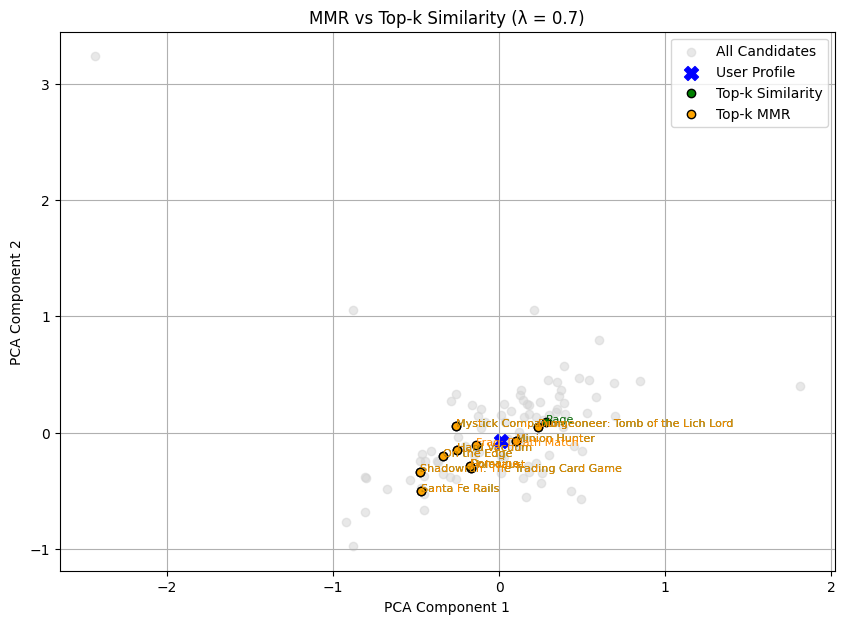

Recommended games for user 'jbuergel'
                                   name   rating    id  similarity  \
432                       Minion Hunter  6.21185   679    0.949177   
1215   Shadowrun: The Trading Card Game  6.46493  2123    0.928653   
1221                        On the Edge  6.29387  2135    0.924965   
1463                  Frag: Death Match  6.34857  2475    0.942455   
2000                          Holocaust  6.50000  3286    0.925185   
2051                        Hard Vacuum  7.37143  3340    0.911645   
2059                     Santa Fe Rails  6.79856  3348    0.917587   
2367                  Mystick Companion  6.62381  3772    0.922502   
3785  Dungeoneer: Tomb of the Lich Lord  6.09815  5576    0.908819   
3904                            Domaine  6.98587  5737    0.926337   

                                            explanation  
432   I recommend this game because you liked 'The G...  
1215  I recommend this game because you liked 'Bus' ...  
1221  I recommend

In [89]:
user_name = "jbuergel"
recommendations = recommend_content_based_mmr(
    user_name,
    games,
    filtered_reviews,
    max_playingtime=60,
    min_age=12,
    minplayers=2,
    maxplayers=4,
    min_rating=6,
    plot = True)

print(f"Recommended games for user '{user_name}'")
print(recommendations)

In [90]:
if recommendations is not None:
    for idx, row in recommendations.iterrows():
        print(f"{row['name']} (Rating: {row['rating']:.2f})")
        print(f"Similarity: {row['similarity']:.2f}")
        print(f"{row['explanation']}\n")

Minion Hunter (Rating: 6.21)
Similarity: 0.95
I recommend this game because you liked 'The Great Khan Game' (you rated it 7.0/10). This game has a 'serious' feeling and is 'strategic'.

Shadowrun: The Trading Card Game (Rating: 6.46)
Similarity: 0.93
I recommend this game because you liked 'Bus' (you rated it 7.0/10). This game has a 'dark' feeling and is 'competitive'.

On the Edge (Rating: 6.29)
Similarity: 0.92
I recommend this game because you liked 'RoboRally' (you rated it 8.0/10). This game has a 'dark' feeling and is 'cooperative'.

Frag: Death Match (Rating: 6.35)
Similarity: 0.94
I recommend this game because you liked 'Paths of Glory' (you rated it 6.0/10). This game has a 'dark' feeling and is 'competitive'.

Holocaust (Rating: 6.50)
Similarity: 0.93
I recommend this game because you liked 'The Great Khan Game' (you rated it 7.0/10). This game has a 'dark' feeling and is 'competitive'.

Hard Vacuum (Rating: 7.37)
Similarity: 0.91
I recommend this game because you liked 'And

##### Cluster diversity content-based system

This other method introduces diversity by grouping candidate games into clusters before selecting recommendations. Instead of simply picking the most similar games overall, we first apply K-Means clustering to partition the games into different groups based on their GloVe embeddings.

Then, we select top candidates from multiple clusters, ensuring that the recommendations are not only relevant to the user's preferences but also draen from different thematic areas within the dataset.

In [91]:
def visualize_clusters(user_profile, game_vectors, cluster_labels, candidate_ids, recommended_ids, id_to_name):
    # Reduce dimensions with PCA
    pca = PCA(n_components=2)
    all_points = np.vstack([user_profile, game_vectors])
    pca_result = pca.fit_transform(all_points)

    user_pca = pca_result[0]
    games_pca = pca_result[1:]

    plt.figure(figsize=(10, 7))

    # Plot games, colored by cluster
    for cluster in np.unique(cluster_labels):
        idxs = np.where(cluster_labels == cluster)[0]
        plt.scatter(games_pca[idxs, 0], games_pca[idxs, 1], label=f"Cluster {cluster}", alpha=0.6)

    # Highlight recommended games and display their names below
    recommended_idxs = [candidate_ids.index(i) for i in recommended_ids if i in candidate_ids]
    for idx in recommended_idxs:
        x, y = games_pca[idx, 0], games_pca[idx, 1]
        plt.scatter(x, y, s=20, color='black')  # Black dot for recommended games
        # Display the game name below the point
        plt.text(x, y - 0.05, id_to_name[candidate_ids[idx]], fontsize=10, color='black', ha='center')

    # Plot user profile
    plt.scatter(user_pca[0], user_pca[1], color='red', s=150, marker='X', label='User Profile')

    # Set the plot labels and title
    plt.xlabel("PCA 1", fontsize=14)
    plt.ylabel("PCA 2", fontsize=14)
    plt.title("PCA Projection of Game Clusters", fontsize=16)

    # Add legend and grid
    plt.legend(loc="best", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()

In [92]:
def recommend_content_based_cluster(user_name, games, reviews, top_k=10, testing = False, max_playingtime=None, min_age=None, minplayers=None, maxplayers=None, min_rating=None, n_clusters=5, plot=False):
    # Filter games based on user preferences
    filtered_games = games.copy()

    if max_playingtime is not None:
        filtered_games = filtered_games[filtered_games["playingtime"] <= max_playingtime]
    if min_age is not None:
        filtered_games = filtered_games[filtered_games["minage"] >= min_age]
    if minplayers is not None:
        filtered_games = filtered_games[filtered_games["minplayers"] <= minplayers]
    if maxplayers is not None:
        filtered_games = filtered_games[filtered_games["maxplayers"] >= maxplayers]
    if min_rating is not None:
        filtered_games = filtered_games[filtered_games["rating"] >= min_rating]

    if filtered_games.empty:
        print("No games match the provided filters.")
        return

    # Get games the user liked
    liked_game_ids = reviews[(reviews["user"] == user_name) & (reviews["rating"] >= 6)]
    liked_vectors = liked_game_ids.merge(games[["id", "glove_vector"]], left_on="ID", right_on="id")

    if liked_vectors.empty:
        print("Not enough liked games with vectors to build a profile.")
        return

    # Build user profile (weighted average)
    ratings = liked_vectors["rating"].values
    weights = ratings / ratings.max()
    vectors = np.vstack(liked_vectors["glove_vector"])
    user_profile = np.average(vectors, axis=0, weights=weights)

    if not testing:
    # Remove already liked games from recommendations
        unseen_mask = ~filtered_games["id"].isin(liked_game_ids["ID"])
        filtered_games = filtered_games[unseen_mask]

    if filtered_games.empty:
        print("No new games to recommend after filtering out liked ones")
        return

    # Cluster candidate games
    game_vectors = np.vstack(filtered_games["glove_vector"].values)
    candidate_ids = filtered_games["id"].tolist()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(game_vectors)

    # Compute similarities
    similarities = cosine_similarity(game_vectors, [user_profile]).flatten()

    # Pick top games from each cluster
    cluster_recommendations = []
    for cluster_id in range(n_clusters):
        indices_in_cluster = np.where(cluster_labels == cluster_id)[0]
        if len(indices_in_cluster) == 0:
            continue
        # Sort games in cluster by similarity
        cluster_sims = similarities[indices_in_cluster]
        sorted_idx = indices_in_cluster[np.argsort(cluster_sims)[::-1]]
        for i in sorted_idx[:min(top_k // n_clusters + 1, len(sorted_idx))]:
            cluster_recommendations.append((candidate_ids[i], similarities[i]))

    # Sort all selected games by similarity and return top_k
    sorted_final = sorted(cluster_recommendations, key=lambda x: x[1], reverse=True)[:top_k]
    selected_ids = [x[0] for x in sorted_final]

    recommended_games = filtered_games[filtered_games["id"].isin(selected_ids)].copy()
    recommended_games["similarity"] = [x[1] for x in sorted_final]

    # Generate personalized explanations with vibe and emotion
    explanations = []
    for game_id in selected_ids:
        # Find the most similar liked game
        similarities_to_liked_games = cosine_similarity(
            [games.loc[games["id"] == game_id, "glove_vector"].values[0]],
            liked_vectors["glove_vector"].tolist()
        ).flatten()
        most_similar_game_idx = np.argmax(similarities_to_liked_games)
        most_similar_game_id = liked_game_ids.iloc[most_similar_game_idx]["ID"]
        most_similar_game_name = games.loc[games["id"] == most_similar_game_id, "name"].values[0]
        most_similar_rating = liked_game_ids.iloc[most_similar_game_idx]["rating"]

        # Get predicted vibe and emotion for the recommended game
        predicted_vibe = games.loc[games["id"] == game_id, "predicted_vibe"].values[0]
        predicted_emotion = games.loc[games["id"] == game_id, "predicted_emotion"].values[0]

        # Generate the explanation
        explanation = (
            f"I recommend this game because you liked '{most_similar_game_name}' "
            f"(you rated it {most_similar_rating}/10). "
            f"This game has a '{predicted_emotion}' feeling and is '{predicted_vibe}'."
        )
        explanations.append(explanation)

    recommended_games["explanation"] = explanations

    if plot:
        id_to_name = dict(zip(games["id"], games["name"]))
        visualize_clusters(user_profile, game_vectors, cluster_labels, candidate_ids, selected_ids, id_to_name)

    return recommended_games[["name", "rating", "id", "similarity", "explanation"]]

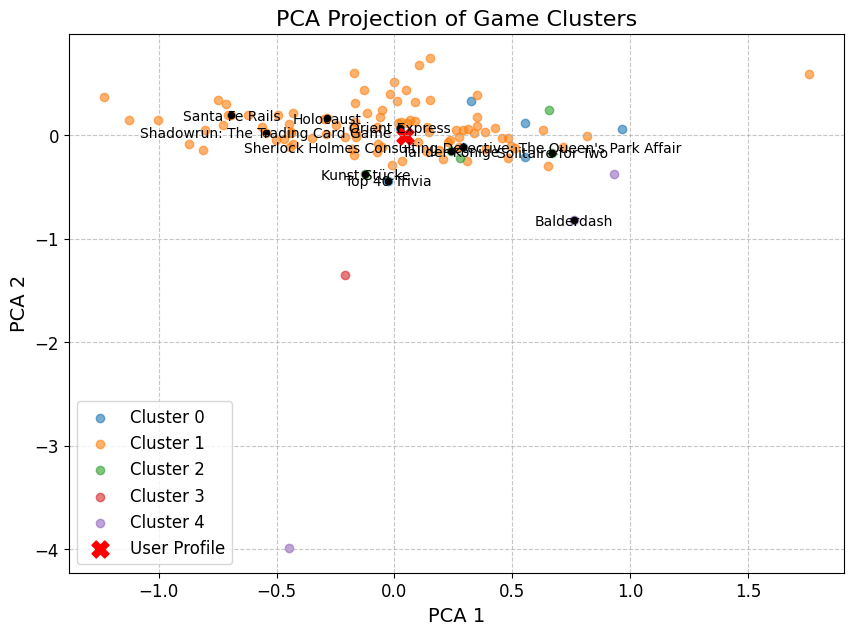

Recommended games for user 'Pyrogal'
                                                   name   rating    id  \
3                                        Tal der Könige  6.61540     4   
106                                          Balderdash  6.47848   163   
569                                        Kunst Stücke  6.38444   910   
1215                   Shadowrun: The Trading Card Game  6.46493  2123   
1403                                     Orient Express  6.68539  2363   
1540                                  Solitaire for Two  6.67939  2602   
1970  Sherlock Holmes Consulting Detective: The Quee...  7.52707  3225   
2000                                          Holocaust  6.50000  3286   
2059                                     Santa Fe Rails  6.79856  3348   
3250                                      Top 40 Trivia  6.50000  4929   

      similarity                                        explanation  
3       0.922122  I recommend this game because you liked 'RoboR...  
106     

In [93]:
user_name = "Pyrogal"
recommendations = recommend_content_based_cluster(
    user_name,
    games,
    filtered_reviews,
    max_playingtime=60,
    min_age=12,
    minplayers=2,
    maxplayers=4,
    min_rating=6,
    plot = True)
print(f"Recommended games for user '{user_name}'")
print(recommendations)

In [94]:
if recommendations is not None:
    for idx, row in recommendations.iterrows():
        print(f"{row['name']} (Rating: {row['rating']:.2f})")
        print(f"Similarity: {row['similarity']:.2f}")
        print(f"{row['explanation']}\n")

Tal der Könige (Rating: 6.62)
Similarity: 0.92
I recommend this game because you liked 'RoboRally' (you rated it 6.0/10). This game has a 'dark' feeling and is 'competitive'.

Balderdash (Rating: 6.48)
Similarity: 0.92
I recommend this game because you liked 'Empire Builder' (you rated it 7.0/10). This game has a 'dark' feeling and is 'competitive'.

Kunst Stücke (Rating: 6.38)
Similarity: 0.92
I recommend this game because you liked 'RoboRally' (you rated it 6.0/10). This game has a 'serious' feeling and is 'strategic'.

Shadowrun: The Trading Card Game (Rating: 6.46)
Similarity: 0.84
I recommend this game because you liked 'RoboRally' (you rated it 6.0/10). This game has a 'intense' feeling and is 'educational'.

Orient Express (Rating: 6.69)
Similarity: 0.82
I recommend this game because you liked 'RoboRally' (you rated it 6.0/10). This game has a 'nostalgic' feeling and is 'competitive'.

Solitaire for Two (Rating: 6.68)
Similarity: 0.82
I recommend this game because you liked 'Hun

##### Diversity-based RecSys comparison

Now we need to evaluate and compare the performance of the three content-based recommendation strategies introduced earlier.

The goal is to assess how each method balances accuracy and diversity in the recommendations.

We will be using precision and recall at top-k as evaluation metrics, both for an individual user and averaged across multiple users. This allows us to quantify how well each system recovers games the user actually liked, and observe the trade-offs between relevance and variety.

In [95]:
reviews[(reviews["user"] == 'jbuergel') & (reviews["rating"] >= 6)]

,Unnamed: 0,user,rating,comment,ID,name
113425,1133921,jbuergel,7.0,"A landmark game for me, as it opened the door ...",13,CATAN
136479,1364711,jbuergel,7.0,"Pleasant enough, but I don't love it. I'm not...",822,Carcassonne
321767,3019297,jbuergel,9.0,"A personal inspiration, Uwe Rosenberg here loo...",11,Bohnanza
395539,3757155,jbuergel,6.0,"Another Rummy-style game, the shine came off o...",50,Lost Cities
527645,5402389,jbuergel,9.0,"A pure auction game, this is outstanding filler.",172,For Sale
...,...,...,...,...,...,...
2145215,25159137,jbuergel,7.0,"A number of clever bits, and the theme is inte...",956,Azteca
2149224,25247762,jbuergel,7.0,"This works better than it has any right to, wi...",2758,Bridgette
2150387,25290417,jbuergel,6.0,"The card deck is a disaster, with far too much...",2760,Knights of the Dinner Table: Orcs at the Gates
2155353,25366977,jbuergel,6.0,Why do most zombie games suck? This is at lea...,752,Maul of America


In [96]:
def get_highly_rated_games(reviews_df, user_name, rating_threshold=6):
    user_reviews = reviews_df[(reviews_df["user"] == user_name) & (reviews_df["rating"] >= rating_threshold)]
    return user_reviews

def precision_recall_manual(user_name, recommendations, highly_rated_games, k=10, threshold=6.0):
    relevant_ids = highly_rated_games["ID"].unique()  # All games the user rated highly

    # Top-k recommended game IDs
    rec_ids = recommendations["id"].head(k).values if not recommendations.empty else []

    # True positives
    hits = len(set(rec_ids) & set(relevant_ids))

    precision = hits / len(rec_ids) if len(rec_ids) > 0 else 0
    recall = hits / len(relevant_ids) if len(relevant_ids) > 0 else 0
    return precision, recall

We generate recommendations for a user using each of the three methods, applying the same filtering preferences.

In [97]:
user1 = "jbuergel"
highly_rated_games_user1 = get_highly_rated_games(filtered_reviews, user1, rating_threshold=6)

In [98]:
recs_basic = recommend_content_based_basic(
    user1, games, highly_rated_games_user1, testing = True, max_playingtime=60, min_age=12, minplayers=2, maxplayers=4)

recs_mmr = recommend_content_based_mmr(
    user1, games, highly_rated_games_user1, testing = True,  max_playingtime=60, min_age=12, minplayers=2, maxplayers=4)

recs_cluster = recommend_content_based_cluster(
    user1, games, highly_rated_games_user1, testing = True, max_playingtime=60, min_age=12, minplayers=2, maxplayers=4)

In [99]:
precision_basic, recall_basic = precision_recall_manual(
    user1, recs_basic, highly_rated_games_user1, k=5, threshold=6.0)
precision_mmr, recall_mmr = precision_recall_manual(
    user1, recs_mmr, highly_rated_games_user1, k=5, threshold=6.0)
precision_cluster, recall_cluster = precision_recall_manual(
    user1, recs_cluster, highly_rated_games_user1, k=5, threshold=6.0)

print(f"Precision@5 Basic: {precision_basic:.4f}")
print(f"Recall@5 Basic: {recall_basic:.4f}")

print(f"\nPrecision@5 MMR: {precision_mmr:.4f}")
print(f"Recall@5M MRR: {recall_mmr:.4f}")

print(f"\nPrecision@5 Cluster: {precision_cluster:.4f}")
print(f"Recall@5 Cluster: {recall_cluster:.4f}")

Precision@5 Basic: 0.0000
Recall@5 Basic: 0.0000

Precision@5 MMR: 0.2000
Recall@5M MRR: 0.0080

Precision@5 Cluster: 0.0000
Recall@5 Cluster: 0.0000


Now we defined a general evaluation function to assess how each method performs across multiple users, not just one.

In [100]:
def evaluate_multiple_users(reviews_df, games_df, recommend_funcs, k=5, n_users=30, rating_threshold=6.0):
    """
    Evaluate average precision and recall over multiple users who have rated at least one game above the threshold.
    """
    users = reviews_df["user"].unique()
    random.shuffle(users)  # shuffle for randomness

    results = {method: {"precision": [], "recall": []} for method in recommend_funcs.keys()}
    evaluated_users = 0

    for user in users:
        highly_rated = get_highly_rated_games(reviews_df, user, rating_threshold)

        if highly_rated.empty:
            continue  # skip users with no high ratings

        for method_name, func in recommend_funcs.items():
            recs = func(user, games_df, highly_rated, testing=True,
                        max_playingtime=60, min_age=12, minplayers=2, maxplayers=4)

            precision, recall = precision_recall_manual(user, recs, highly_rated, k=k, threshold=rating_threshold)
            results[method_name]["precision"].append(precision)
            results[method_name]["recall"].append(recall)

        evaluated_users += 1
        if evaluated_users >= n_users:
            break  # stop once we have enough valid users

    # Compute average metrics
    avg_results = {}
    for method, metrics in results.items():
        avg_precision = sum(metrics["precision"]) / len(metrics["precision"]) if metrics["precision"] else 0
        avg_recall = sum(metrics["recall"]) / len(metrics["recall"]) if metrics["recall"] else 0
        avg_results[method] = {"avg_precision": avg_precision, "avg_recall": avg_recall}

    return avg_results

In [101]:
recommend_funcs = {
    "basic": recommend_content_based_basic,
    "mmr": recommend_content_based_mmr,
    "cluster": recommend_content_based_cluster
}

avg_metrics = evaluate_multiple_users(
    filtered_reviews, games,
    recommend_funcs=recommend_funcs,
    k=5, n_users=40, rating_threshold=6.0
)

for method, metrics in avg_metrics.items():
    print(f"{method.upper()} - Avg Precision@5: {metrics['avg_precision']:.4f}, Avg Recall@5: {metrics['avg_recall']:.4f}")

BASIC - Avg Precision@5: 0.0400, Avg Recall@5: 0.0448
MMR - Avg Precision@5: 0.0700, Avg Recall@5: 0.0468
CLUSTER - Avg Precision@5: 0.0450, Avg Recall@5: 0.0408


##### Hybrid content-based recommender system

Now we will try a hybrid recommender system, which is called hybrid because it comines elements from collaborative filtering and content-based filtering.

The content-based part is achieved using the GloVe vectors to represent each game, and the collaborative by using user rating behavior.

Note we only take the k most similar games. This is done in order to prevent bias towards the weighted mean of the user ratings. When a user has many rated games, the prediction of any of the rest of target games will converge to a number very close to the mean.

In [ ]:
def predict_rating(user_name, target_game_id, games_df, reviews_df, k=10):
    # Get user-rated games
    user_reviews = reviews_df[(reviews_df["user"] == user_name)]

    if user_reviews.empty:
        return "No reviews found for this user."

    # Merge with games to get GloVe vectors
    user_games = user_reviews.merge(games_df[["id", "glove_vector"]], left_on="ID", right_on="id")

    if user_games.empty:
        return "User has rated games with no vector information."

    # Get vector of target game
    try:
        target_vector = games_df.loc[games_df["id"] == target_game_id, "glove_vector"].values[0]
    except IndexError:
        return "Target game ID not found in games dataset."

    # Compute cosine similarities
    rated_vectors = np.vstack(user_games["glove_vector"])
    similarities = cosine_similarity(rated_vectors, [target_vector]).flatten()
    similarities = np.maximum(similarities, 0)  # Ensure no negatives

    ratings = user_games["rating"].values

    # Get indices of top-k similar games
    if len(similarities) < k:
        k = len(similarities)
    top_k_idx = np.argsort(similarities)[-k:]

    top_similarities = similarities[top_k_idx]
    top_ratings = ratings[top_k_idx]

    if top_similarities.sum() == 0:
        return "No sufficiently similar games found."

    # Weighted average using top-k
    predicted_rating = np.average(top_ratings, weights=top_similarities)

    return round(predicted_rating, 2)

In [ ]:
def predict_rating_with_explanation(user_name, target_game_id, games_df, reviews_df, k=10):
    user_reviews = reviews_df[reviews_df["user"] == user_name]
    if user_reviews.empty:
        return None, "No reviews found for this user."

    user_games = user_reviews.merge(games_df[["id", "glove_vector", "name"]], left_on="ID", right_on="id")
    if user_games.empty:
        return None, "User has rated games with no vector information."
    try:
        target_vector = games_df.loc[games_df["id"] == target_game_id, "glove_vector"].values[0]
    except IndexError:
        return None, "Target game ID not found in games dataset."

    rated_vectors = np.vstack(user_games["glove_vector"])
    similarities = cosine_similarity(rated_vectors, [target_vector]).flatten()
    similarities = np.maximum(similarities, 0)

    ratings = user_games["rating"].values

    if len(similarities) < k:
        k = len(similarities)
    top_k_idx = np.argsort(similarities)[-k:]

    top_similarities = similarities[top_k_idx]
    top_ratings = ratings[top_k_idx]
    top_game_names = user_games.iloc[top_k_idx]["name_y"].tolist()

    if top_similarities.sum() == 0:
        return None, "No sufficiently similar games found."

    predicted_rating = round(np.average(top_ratings, weights=top_similarities), 2)

    # Build explanation
    if len(top_game_names) == 1:
        explanation = f"Because you liked **{top_game_names[0]}**, and this game is similar to it."
    elif len(top_game_names) == 2:
        explanation = f"Because you liked **{top_game_names[0]}** and **{top_game_names[1]}**, and this game is similar to both."
    else:
        explanation = f"Because you liked games like **{top_game_names[0]}**, **{top_game_names[1]}**, and others."

    return predicted_rating, explanation

The next code is to check range of predictions in all target games

In [ ]:
def predict_all_ratings(user_name, games_df, reviews_df, k=10):
    # Get user-rated games and their vectors
    user_reviews = reviews_df[reviews_df["user"] == user_name]
    if user_reviews.empty:
        return "No reviews found for this user."

    user_games = user_reviews.merge(games_df[["id", "glove_vector"]], left_on="ID", right_on="id")
    if user_games.empty:
        return "User has rated games with no vector information."

    rated_vectors = np.vstack(user_games["glove_vector"])
    rated_ratings = user_games["rating"].values
    rated_names = user_games["name"].tolist()

    # Games not yet rated by user
    unseen_games = games_df[~games_df["id"].isin(user_games["id"])].copy()
    if unseen_games.empty:
        return "No unseen games to predict ratings for."

    predicted_ratings = []

    for _, game in unseen_games.iterrows():
        target_vector = game["glove_vector"]

        # Cosine similarity with all user-rated games
        similarities = cosine_similarity(rated_vectors, [target_vector]).flatten()
        similarities = np.maximum(similarities, 0)

        # Select top-k most similar games
        if len(similarities) < k:
            k_adj = len(similarities)
        else:
            k_adj = k

        top_k_idx = np.argsort(similarities)[-k_adj:]
        top_similarities = similarities[top_k_idx]
        top_ratings = rated_ratings[top_k_idx]
        top_game_names = [rated_names[i] for i in top_k_idx]

        if top_similarities.sum() == 0:
            pred_rating = np.nan
            explanation = "No sufficiently similar games found."
        else:
            pred_rating = np.average(top_ratings, weights=top_similarities)
            # Build explanation
            if len(top_game_names) == 1:
                explanation = f"Because you liked **{top_game_names[0]}**, and this game is similar to it."
            elif len(top_game_names) == 2:
                explanation = f"Because you liked **{top_game_names[0]}** and **{top_game_names[1]}**, and this game is similar to both."
            else:
                explanation = f"Because you liked games like **{top_game_names[0]}**, **{top_game_names[1]}**, and others."

        predicted_ratings.append((game["id"], game["name"], round(pred_rating, 2) if not np.isnan(pred_rating) else None, explanation))

    # Return as a DataFrame
    pred_df = pd.DataFrame(predicted_ratings, columns=["id", "name", "predicted_rating", "explanation"])
    pred_df = pred_df.sort_values(by="predicted_rating", ascending=False)

    return pred_df

In [ ]:
predictions_df = predict_all_ratings("jbuergel", games, reviews, k=10)
predictions_df

It is important, however, to test different values of k (number of similar items considered), since this can affect the predictions:

*   A small k uses the most similar items, hence it is more personalized but probably noisier.
*   A large k uses more items, hence smoother predictions but more biased towards the average.

In [ ]:
def split_reviews_for_user(reviews_df, user_name, test_size=0.3, random_state=42):
    user_reviews = reviews_df[reviews_df["user"] == user_name]

    if user_reviews.empty:
        raise ValueError(f"No reviews found for user {user_name}")

    # Split the reviews into train and test
    train_reviews, test_reviews = train_test_split(user_reviews, test_size=test_size, random_state=random_state)

    return train_reviews, test_reviews

In [ ]:
def predict_all_ratings_k_values_with_rmse(user_name, games_df, reviews_df, test_df, k_values=[5, 10]):
    results = {}

    # Prepare user data
    user_train = reviews_df[reviews_df["user"] == user_name]
    test_data = test_df[test_df["user"] == user_name]

    if user_train.empty or test_data.empty:
        return "Not enough data for user"

    user_games = user_train.merge(games_df[["id", "glove_vector"]], left_on="ID", right_on="id")
    rated_vectors = np.vstack(user_games["glove_vector"])
    rated_ratings = user_games["rating"].values

    for k in k_values:
        predicted = []
        actual = []

        for _, game in test_data.iterrows():
            game_id = game["ID"]
            true_rating = game["rating"]
            try:
                target_vector = games_df.loc[games_df["id"] == game_id, "glove_vector"].values[0]
            except IndexError:
                continue

            sims = cosine_similarity(rated_vectors, [target_vector]).flatten()
            sims = np.maximum(sims, 0)
            top_k_idx = np.argsort(sims)[-k:]
            top_sims = sims[top_k_idx]
            top_ratings = rated_ratings[top_k_idx]

            if top_sims.sum() == 0:
                continue

            pred_rating = np.average(top_ratings, weights=top_sims)
            predicted.append(pred_rating)
            actual.append(true_rating)

        if predicted:
            rmse = sqrt(mean_squared_error(actual, predicted))
            results[k] = rmse

    return results

In [ ]:
user = "jbuergel"
train_df, test_df = split_reviews_for_user(filtered_reviews, user)

rmse_by_k = predict_all_ratings_k_values_with_rmse(
    user_name=user,
    games_df=games,
    reviews_df=train_df,   # this is used for building the user profile
    test_df=test_df,       # this is used for evaluating predictions
    k_values=[3, 5, 10, 15, 20, 30, 40, 50]
)
rmse_by_k

In [ ]:
ks = list(rmse_by_k.keys())
rmse_values = list(rmse_by_k.values())

plt.figure(figsize=(8, 5))
plt.plot(ks, rmse_values, marker='o')
plt.title("RMSE vs. k in Hybrid Content-Based Recommender")
plt.xlabel("k (Top-k similar games used)")
plt.ylabel("RMSE")
plt.grid(True)
plt.xticks(ks)
plt.show()

In [ ]:
predictions_df = predict_rating("jbuergel", 13, games, reviews, k=10)
predictions_df

In [ ]:
predicted_score, explanation = predict_rating_with_explanation("jbuergel", 13, games, reviews, k=10)
if predicted_score is not None:
    print(f"You’d probably rate this game {predicted_score}/10")
    print(explanation)
else:
    print(explanation)

##### Cold Start for Hybrid RecSys

For this project, it is important to highlight that we considered the so-called 'cold-start' scenarios. Cold-start refers to when a user does not have ratings at all or only a few, which makes collaborative or hybrid recommendations unreliable.

Our original hybrid system depends on having enough rated games to compare against, so it doesn't work well when this data is missing.

Because of this, we offer two approaches:

*   Allow users to manually select a few games they like (simulating initial ratings).
*   Recommend games based on popularity and clustering, ensuring relevance and diversity.


**OPTION 1: Cold start with user choosing three games**

In [ ]:
# Simulate cold start user
cold_start_user = "new_user"

# Let’s pretend they selected these game IDs as their favorites
liked_game_ids = [12, 91, 170]  # These must exist in games["id"]

# Create a pseudo-review dataframe for them
cold_reviews = pd.DataFrame({
    "user": [cold_start_user] * len(liked_game_ids),
    "ID": liked_game_ids,
    "rating": [9] * len(liked_game_ids)  # simulate high preference
})

# Run the recommender with this pseudo-profile
cold_recs = recommend_content_based_mmr(
    user_name=cold_start_user,
    games=games,
    reviews=cold_reviews,
    top_k=10,
    max_playingtime=60,
    min_age=12,
    minplayers=2,
    maxplayers=4,
    min_rating=6
)

print(cold_recs)

**OPTION 2: Cold start with popularity-based recommnender**

Before implementing the recommender, we explored two things:

1.   Choosing the number of clusters using the Elbow method.
2.   Visualizing the game space with t-SNE to confirm meaningful clustering.



In [ ]:
# Calculate the inertia (WCSS) for different values of k
inertia = []
k_range = range(1, 30)  # Try different cluster counts

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(np.vstack(games["glove_vector"]))
    inertia.append(kmeans.inertia_)

# Plot the inertia values
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker="o")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (WCSS)")
plt.show()

In [ ]:
games["glove_vector"] = games["glove_vector"].apply(lambda x: np.fromstring(x[1:-1], sep=',') if isinstance(x, str) else x)
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
games["description_cluster"] = kmeans.fit_predict(np.vstack(games["glove_vector"]))

In [ ]:
# Get the embeddings (glove vectors) from the 'glove_vector' column
embeddings = np.vstack(games["glove_vector"])

# Perform t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Add t-SNE results to the games dataframe
games["tsne_1"] = tsne_results[:, 0]
games["tsne_2"] = tsne_results[:, 1]

# Plot t-SNE representation with cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(games["tsne_1"], games["tsne_2"], c=games["description_cluster"], cmap="viridis", alpha=0.7)
plt.colorbar(label="Cluster")
plt.title("t-SNE Visualization of K-Means Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [ ]:
# Compute average ratings and number of ratings per game
ratings = reviews.groupby("ID")["rating"].agg(["mean", "count"]).reset_index()
ratings.columns = ["id", "avg_rating", "num_ratings"]

# Compute popularity score: weighted average of rating and the number of ratings
ratings["popularity_score"] = (ratings["avg_rating"] * ratings["num_ratings"]) / (ratings["num_ratings"] + 10)

# Merge popularity scores with the games DataFrame and add suffixes to avoid column name conflicts
games = games.merge(ratings, left_on="id", right_on="id", how="left", suffixes=('', '_ratings'))

def get_diverse_popular_games(games, top_k=10):
    recommended_games = []

    # Iterate over clusters to get popular games from each cluster
    for cluster in range(games["description_cluster"].nunique()):
        # Get games in the cluster
        games_cluster = games[games["description_cluster"] == cluster]

        # Sort by popularity
        games_cluster = games_cluster.sort_values("popularity_score", ascending=False)

        # Select the top 1 game from each cluster to ensure diversity
        top_game = games_cluster.head(1)
        recommended_games.append(top_game)

    # Combine all recommended games and sort by popularity score
    recommended_games = pd.concat(recommended_games)
    recommended_games = recommended_games.sort_values("popularity_score", ascending=False).head(top_k)

    explanations = []
    for _, row in recommended_games.iterrows():
        cluster = row["description_cluster"]
        rating = round(row["avg_rating"], 2)
        num = int(row["num_ratings"])

        explanation = (
            f"This game is highly rated ({rating}/10 from {num} users) "
            f"and was selected to represent a distinct style or theme (cluster {cluster})."
        )
        explanations.append(explanation)

    recommended_games["explanation"] = explanations

    return recommended_games[["name", "clean_description", "avg_rating", "num_ratings", "popularity_score", "explanation"]]

In [ ]:
cold_recs = get_diverse_popular_games(games, top_k=10)
print(cold_recs)

#### Collaborative filtering

In this section, we implement collaborative filtering approaches using the Surprise library. These methods only rely on ratings, without needing content features. We explore both neighborhood-based and latent factor models.

In [ ]:
# CODE TO MAKE SURPRISE LIBRARY WORK
!pip uninstall -y numpy scikit-surprise tensorflow numba
!pip install numpy==1.26.4
!pip install numba==0.60.0
!pip install scikit-surprise
!pip install tensorflow==2.18.0

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: numba 0.60.0
Uninstalling numba-0.60.0:
  Successfully uninstalled numba-0.60.0
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.7 requires numba>=0.51.2, which is not installed.
dask-cuda 25.2.0 requires numba<0.61.0a0,>=0.59.1, which is not installed.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, which is not installed.
shap 0.47.2 requires numba>=0.54, which is not installed

In [ ]:
from surprise import SVD, Dataset, Reader, accuracy, NMF, KNNBasic
from surprise import KNNWithMeans, KNNBaseline
from surprise.model_selection import GridSearchCV, train_test_split
from collections import defaultdict

##### Data preparation and filtering

We begin by filtering out users by randomly sample to reduce computational cost, and format the data to work with Surprise's rating-based datasets.



In [ ]:
reviews = pd.read_csv("reviews.csv", sep=",")

In [ ]:
# Sample 10000 users to have less reviews
sampled_users = np.random.choice(reviews["user"].unique(), size=10000, replace=False)
sampled_reviews = reviews[reviews["user"].isin(sampled_users)]

In [ ]:
reviews = sampled_reviews
reviews

,Unnamed: 0,user,rating,comment,ID,name
43,43,Narayannis,10.0,NaN,13,CATAN
126,126,Narayannis,10.0,"An excellent game, betrayed by the endless (an...",822,Carcassonne
656,5986,msuspar10,10.0,NaN,13,CATAN
659,5989,pinkunicorn,10.0,Excellent family game!,13,CATAN
784,6114,bigcheese,10.0,Home,822,Carcassonne
...,...,...,...,...,...,...
1871097,26106379,hinj,5.0,"A great sick end-of-the-night ""game"". Definit...",1415,Rat Splatter
1871711,26145827,hinj,7.2,evil game of ocean domination among the fishies.,1277,Fish & Chips
1872214,26182239,GonV,5.0,NaN,676,Ninja Wars
1872230,26182844,clooneyclub,10.0,"A superb game, good enough for me to invest mo...",2041,They're at the Post


We observe the users with the highest number of ratings

In [ ]:
# Count number of ratings per user
top_users = reviews['user'].value_counts().head(10)

# Print
print("Top users by number of ratings:")
print(top_users)


Top users by number of ratings:
user
Trochosa Ruricola    172
wlam                 165
hinj                 147
twoBeatT             146
Corwyn59             127
toniemn              112
thomson              106
Silke_und_Andre      103
DrGrayrock            72
angiolillo            70
Name: count, dtype: int64


As we are using the Surprise library, we need to build a special surprise dataset. Firstly, we define the range of ratings and provide three fields for the dataset: user, ID and rating.

In [ ]:
# Load data
# Range of ratings
reader = Reader(rating_scale=(1, 10))

# Dataset Auto Folds only with user, game ID and rating.
data = Dataset.load_from_df(reviews[["user", "ID", "rating"]], reader)

After this, the data is split into train and test. The train set becomes a surprise dataset, while the test set is a simple python list.

In [ ]:
# Train-test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
print(type(trainset))
print(type(testset))

<class 'surprise.trainset.Trainset'>
<class 'list'>


By printing some samples in the train sets we observe that the samples are composed by a user id, item id and rating. In order to work with this dataset, the IDs have been modified to relative IDs, not the original ones provided from the reviews dataset.

In [ ]:
print(list(trainset.all_ratings())[:10])
# Note the relative user ids.

[(0, 0, 6.0), (0, 44, 5.0), (0, 25, 8.0), (0, 50, 6.0), (0, 51, 6.0), (0, 60, 1.0), (0, 86, 6.0), (0, 88, 8.0), (0, 99, 4.0), (0, 133, 7.0)]


In [ ]:
testset[:10]

[('twoBeatT', 573, 5.0),
 ('wedgeex', 215, 7.5),
 ('DrGrayrock', 119, 6.5),
 ('spcrespo', 1513, 8.0),
 ('hinj', 751, 8.5),
 ('pbice', 552, 8.0),
 ('Nazhuret', 1115, 8.0),
 ('Brob', 320, 5.0),
 ('thgustafson', 822, 7.4),
 ('gtownkel', 257, 7.0)]

##### Neighborhood-based methods


We will begin by exploring KNN-based collaborative filtering, where the rating for a game is predicted based on similar users or items.

We will be hyperparamter tuning k (number of neighbors) and min_k (minimum number of neighbors) using RMSE as a performance metric. Grid search is then applied to test different similarity measures and models like KNNBasic and KNNWithMeans.

To narrow down the gridsearch, we can explore these hyperaparameters with the KNNBasic model to see where does the performance stabilizes. This will also help us to not consider a huge grid during gridsearch.

Trying k = 10
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.5785
Trying k = 20
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.5659
Trying k = 30
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.5658
Trying k = 40
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.5640
Trying k = 50
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.5639
Trying k = 60
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.5642
Trying k = 70
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.5647
Trying k = 80
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.5650
Trying k = 90
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.5652
Trying k = 100
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.5653

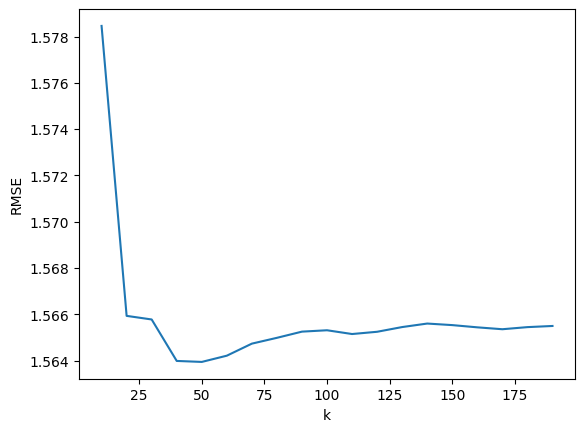

In [ ]:
# Discovering the right value for k_max
range_K = range(10,200,10)
RMSE_K = []

for k in range_K:
    print(f"Trying k = {k}")
    algo = KNNBasic(k=k)
    algo.fit(trainset)
    predictions = algo.test(testset)
    RMSE_K.append(accuracy.rmse(predictions))

plt.plot(range_K, RMSE_K)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.show()

With this plot, we observe that the optimal maximum k lays around 30-60. Values between these will be used in the grid search

The same procedure will be done with min_k, providing the optimal number of minimum neighbours

In [ ]:
# Discovering the right value for min_k
range_minK = range(1, 20)
RMSE_minK = []

for mink in range_minK:
    print(f"Trying min_k = {mink}")
    algo = KNNBasic(k=20, min_k=mink)
    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions, verbose=False)
    RMSE_minK.append(rmse)

plt.plot(range_minK, RMSE_minK, marker='o')
plt.xlabel('min_k')
plt.ylabel('RMSE')
plt.title('RMSE vs. min_k in KNNBasic')
plt.grid(True)
plt.show()

As observed in the plot, the optimal number of minimum neighbors, which reduces the RMSE lays around 5.

Now let's fine ture the parameters by using a grid search, with the method implemented in the surprise library. In order to work with this method, the complete dataset must be provided to the grid search, not the separated train and test sets.

The similarities options we will test are 'cosine' (based on cosine similarity) and 'pearson' (based on pearson correlation).

For this project, only item based approaches will be tested. We will avoid user based due to computational power and scope of the project.

In [ ]:
# Define parameters
param_grids = {
    'KNNBasic': {
        'k': [30, 40, 50, 60, 70],
        'min_k': [3, 6, 7],
        'sim_options': {
            'name': ['cosine', 'pearson'],
            'user_based': [False],
        }
    },
    'KNNWithMeans': {
        'k': [30, 40, 50, 60, 70],
        'min_k': [3, 6, 7],
        'sim_options': {
            'name': ['cosine', 'pearson'],
            'user_based': [False],
        }
    }
}

# Store results
results = []
best_models = {}  # To store the best model for each algorithm

# Loop through algorithms and perform grid search
for algo_name, param_grid in param_grids.items():
    algo_class = eval(algo_name)
    gs = GridSearchCV(algo_class, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
    gs.fit(data)  # Fit on the full dataset to find best parameters

    # Store the best model
    best_models[algo_name] = gs.best_estimator['rmse']

    # Store the result of the grid search
    results.append({
        'Algorithm': algo_name,
        'Best RMSE': gs.best_score['rmse'],
        'Best MAE': gs.best_score['mae'],
        'Best Params': gs.best_params['rmse']
    })

    # Plotting the best k values
    # Extract k values and corresponding RMSE scores
    k_values = param_grid['k']
    rmse_scores = []

    # Loop through each k value and find corresponding RMSE score
    for k in k_values:
        # Filter out the corresponding scores for each k value
        mask = [params['k'] == k for params in gs.cv_results['params']]
        k_rmse_scores = [gs.cv_results['mean_test_rmse'][i] for i in range(len(gs.cv_results['params'])) if mask[i]]
        rmse_scores.append(k_rmse_scores[0])  # Assuming only one score per k value

    plt.figure(figsize=(8, 6))
    plt.plot(k_values, rmse_scores, marker='o', linestyle='-', color='b')
    plt.title(f'RMSE vs. k for {algo_name}')
    plt.xlabel('k')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.show()

In [ ]:
# Show results of the grid search
results_df = pd.DataFrame(results)
results_df

In [ ]:
for index, row in results_df.iterrows():
    print(f"Algorithm: {row['Algorithm']}")
    print(f"Best Params: {row['Best Params']}")
    print("-" * 20)

In [ ]:
# Choose the best algorithm based on the best RMSE from the grid search
best_algorithm_name = results_df.loc[results_df['Best RMSE'].idxmin()]['Algorithm']
best_model = best_models[best_algorithm_name]
print(f"Using the best model: {best_algorithm_name} with parameters: {results_df.loc[results_df['Best RMSE'].idxmin()]['Best Params']}")

Once we have found the best model, we can test its ability to recommend games to a specific user.

In [ ]:
best_model = KNNWithMeans(k=50, min_k=5, sim_options={'name': 'cosine', 'user_based': False})
best_model.fit(trainset)

import pickle

# Save KNNWithMeans model
with open("knn_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

user = 'jbourgel'

# Games the user has already rated
rated_game_ids = reviews[reviews["user"] == user]["ID"].unique()

# All possible game IDs
all_game_ids = games["id"].unique()

# Filter out the ones already rated
unseen_game_ids = [gid for gid in all_game_ids if gid not in rated_game_ids]

# Predict ratings for the unseen games
predictions_user = [(gid, best_model.predict(user, gid).est) for gid in unseen_game_ids]

# Sort by predicted rating
top_k = 10
top_predictions = sorted(predictions_user, key=lambda x: x[1], reverse=True)[:top_k]

# Get game info from the original games DataFrame
top_game_ids = [pred[0] for pred in top_predictions]
recommended_games = games[games["id"].isin(top_game_ids)][["id", "name", "rating"]]

print("\nTop Recommended Games:")
print(recommended_games.reset_index(drop=True))

Computing the cosine similarity matrix...
Done computing similarity matrix.

Top Recommended Games:
   id                name   rating
0   1          Die Macher  7.58777
1   2        Dragonmaster  6.66468
2   3             Samurai  7.47596
3   4      Tal der Könige  6.61540
4   5             Acquire  7.35053
5   6  Mare Mediterraneum  6.45230
6   7           Cathedral  6.54958
7   8   Lords of Creation  6.05322
8   9        El Caballero  6.46943
9  10           Elfenland  6.67221


In [ ]:
# Get predictions on test set
predictions = best_model.test(testset)

# Calculate performance metrics
print("Evaluation Metrics:")
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

Evaluation Metrics:
RMSE: 1.4826
MAE:  1.1275


In [ ]:
# Precision@K and Recall@K (k = 10 by default)
def precision_recall_at_k(predictions, k=10, threshold=7.0):
    # Map user to list of (item_id, true_rating, est_rating)
    # Here we group predictions by user
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((iid, true_r, est))

    precisions = dict()
    recalls = dict()

    # For each user we simulate getting their top-k recommendations:
    for uid, user_ratings in user_est_true.items():
        # Sort by estimated rating
        user_ratings.sort(key=lambda x: x[2], reverse=True)
        top_k = user_ratings[:k]

        # How many relevant items are in the test set? (true_rating ≥ 8)
        n_rel = sum((true_r >= threshold) for (_, true_r, _) in user_ratings)

        # How many of the top-k recommended items are estimated to be ≥ 8?
        n_rec_k = sum((est >= threshold) for (_, _, est) in top_k)

        # How many are both relevant and recommended?
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (_, true_r, est) in top_k)

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Average over all users
    avg_precision = sum(precisions.values()) / len(precisions)
    avg_recall = sum(recalls.values()) / len(recalls)
    return avg_precision, avg_recall

In [ ]:
precision, recall = precision_recall_at_k(predictions, k=10)
print(f"Precision@10: {precision:.4f}")
print(f"Recall@10: {recall:.4f}")

Precision@10: 0.4400
Recall@10: 0.4066


##### Latent based methods

Before ending this section of collaborative filtering, we also wanted to test latent factor models. These try to compress user and item interactions into a smaller set of hidden features.

These methods try to uncover the underlying structure in rating data, capturing things like genre preference, complexity tolerance, or thematic interests.

We test two models from the Surprise library:

*   SVD (Singular Value Decomposition): Learns latent factors via matrix factorization using gradient descent.
*   NMF (Non-negative Matrix Factorization): Learns additive latent components, and it is often more interpretable.

Value of nlatents: 1
RMSE: 2.2045
Value of nlatents: 6
RMSE: 1.9752
Value of nlatents: 11
RMSE: 2.0191
Value of nlatents: 16
RMSE: 2.0512
Value of nlatents: 21
RMSE: 2.0770
Value of nlatents: 26
RMSE: 2.0819
Value of nlatents: 31
RMSE: 2.0878
Value of nlatents: 36
RMSE: 2.1463
Value of nlatents: 41
RMSE: 2.1424
Value of nlatents: 46
RMSE: 2.1568
Value of nlatents: 51
RMSE: 2.2032
Value of nlatents: 56
RMSE: 2.2193
Value of nlatents: 61
RMSE: 2.2319
Value of nlatents: 66
RMSE: 2.2416
Value of nlatents: 71
RMSE: 2.2631
Value of nlatents: 76
RMSE: 2.2742
Value of nlatents: 81
RMSE: 2.2925
Value of nlatents: 86
RMSE: 2.2683
Value of nlatents: 91
RMSE: 2.3087
Value of nlatents: 96
RMSE: 2.3457
Value of nlatents: 101
RMSE: 2.3890
Value of nlatents: 106
RMSE: 2.3400
Value of nlatents: 111
RMSE: 2.3745
Value of nlatents: 116
RMSE: 2.4214
Value of nlatents: 121
RMSE: 2.4176
Value of nlatents: 126
RMSE: 2.4351
Value of nlatents: 131
RMSE: 2.4470
Value of nlatents: 136
RMSE: 2.4627
Value of nlate

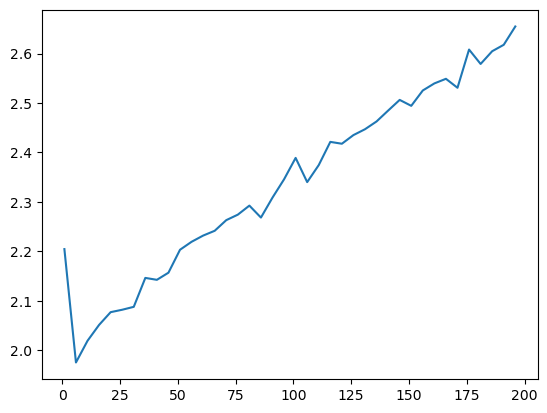

In [ ]:
range_nlatents =  range(1,200, 5)
RMSE_nlatents = []
for nlatents in range_nlatents:
  print('Value of nlatents: ' + str(nlatents))
  algoLatent = SVD(n_factors = nlatents, biased = False)
  algoLatent.fit(trainset)
  predictions = algoLatent.test(testset)
  RMSE_nlatents.append(accuracy.rmse(predictions))

plt.figure()
plt.plot(range_nlatents, RMSE_nlatents)


Value of nlatents: 1
RMSE: 1.3573
Value of nlatents: 6
RMSE: 1.3584
Value of nlatents: 11
RMSE: 1.3600
Value of nlatents: 16
RMSE: 1.3567
Value of nlatents: 21
RMSE: 1.3620
Value of nlatents: 26
RMSE: 1.3613
Value of nlatents: 31
RMSE: 1.3656
Value of nlatents: 36
RMSE: 1.3655
Value of nlatents: 41
RMSE: 1.3631
Value of nlatents: 46
RMSE: 1.3557
Value of nlatents: 51
RMSE: 1.3650
Value of nlatents: 56
RMSE: 1.3602
Value of nlatents: 61
RMSE: 1.3594
Value of nlatents: 66
RMSE: 1.3679
Value of nlatents: 71
RMSE: 1.3705
Value of nlatents: 76
RMSE: 1.3685
Value of nlatents: 81
RMSE: 1.3546
Value of nlatents: 86
RMSE: 1.3686
Value of nlatents: 91
RMSE: 1.3674
Value of nlatents: 96
RMSE: 1.3616
Value of nlatents: 101
RMSE: 1.3879
Value of nlatents: 106
RMSE: 1.3699
Value of nlatents: 111
RMSE: 1.3639
Value of nlatents: 116
RMSE: 1.3637
Value of nlatents: 121
RMSE: 1.3789
Value of nlatents: 126
RMSE: 1.3724
Value of nlatents: 131
RMSE: 1.3717
Value of nlatents: 136
RMSE: 1.3718
Value of nlate

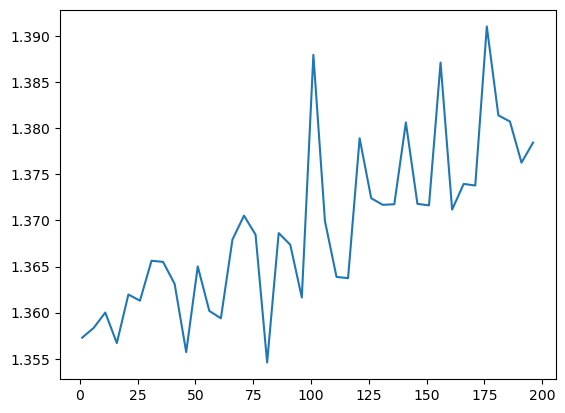

In [ ]:
range_nlatents =  range(1,200, 5)
RMSE_nlatents = []
for nlatents in range_nlatents:
  print('Value of nlatents: ' + str(nlatents))
  algoLatent = SVD(n_factors = nlatents, biased = True)
  algoLatent.fit(trainset)
  predictions = algoLatent.test(testset)
  RMSE_nlatents.append(accuracy.rmse(predictions))

plt.figure()
plt.plot(range_nlatents, RMSE_nlatents)


The purpose of the previous plots is to check if the 'biased' parameter a.  we can observe that by setting the biased parameter to True we obtain lower ranges of RMSE

In [ ]:
from surprise import SVD, NMF
from surprise.model_selection import GridSearchCV

# Define models and corresponding grids
param_grids = {
    'SVD': {
        'n_factors': [50, 100, 150],
        'biased': [True],
        'lr_all': [0.002, 0.005],
        'reg_all': [0.02, 0.1]
    },
    'NMF': {
        'n_factors': [50, 100, 150],
        'reg_pu': [0.06, 0.1],
        'reg_qi': [0.06, 0.1]
    }
}

# Store results
results = []
best_models = {}  # To store the best model for each algorithm

# Loop through algorithms and perform grid search
for algo_name, param_grid in param_grids.items():
    algo_class = eval(algo_name)
    gs = GridSearchCV(algo_class, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
    gs.fit(data)  # Fit on the full dataset to find best parameters

    # Store the best model
    best_models[algo_name] = gs.best_estimator

    # Store the result of the grid search
    results.append({
        'Algorithm': algo_name,
        'Best RMSE': gs.best_score['rmse'],
        'Best MAE': gs.best_score['mae'],
        'Best Params': gs.best_params['rmse']
    })

    # Plotting the RMSE values for different hyperparameters
    if algo_name == 'SVD':
        # Extract parameters for plotting RMSE
        n_factors = param_grid['n_factors']
        lr_all = param_grid['lr_all']
        reg_all = param_grid['reg_all']

        # Plot RMSE across n_factors, lr_all, reg_all
        plt.figure(figsize=(8, 6))
        for lr in lr_all:
            for reg in reg_all:
                rmse_scores = []
                for nf in n_factors:
                    mask = [(params['n_factors'] == nf) and (params['lr_all'] == lr) and (params['reg_all'] == reg)
                            for params in gs.cv_results['params']]
                    rmse_scores.append([gs.cv_results['mean_test_rmse'][i] for i in range(len(gs.cv_results['params'])) if mask[i]][0])

                plt.plot(n_factors, rmse_scores, marker='o', label=f'lr={lr}, reg={reg}')

        plt.title('RMSE vs n_factors for SVD')
        plt.xlabel('n_factors')
        plt.ylabel('RMSE')
        plt.legend()
        plt.grid(True)
        plt.show()

    elif algo_name == 'NMF':
        # Extract parameters for plotting RMSE
        n_factors = param_grid['n_factors']
        reg_pu = param_grid['reg_pu']
        reg_qi = param_grid['reg_qi']

        # Plot RMSE across n_factors, reg_pu, reg_qi
        plt.figure(figsize=(8, 6))
        for rp in reg_pu:
            for rq in reg_qi:
                rmse_scores = []
                for nf in n_factors:
                    mask = [(params['n_factors'] == nf) and (params['reg_pu'] == rp) and (params['reg_qi'] == rq)
                            for params in gs.cv_results['params']]
                    rmse_scores.append([gs.cv_results['mean_test_rmse'][i] for i in range(len(gs.cv_results['params'])) if mask[i]][0])

                plt.plot(n_factors, rmse_scores, marker='o', label=f'reg_pu={rp}, reg_qi={rq}')

        plt.title('RMSE vs n_factors for NMF')
        plt.xlabel('n_factors')
        plt.ylabel('RMSE')
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
# Show results of the grid search
results_df = pd.DataFrame(results)
results_df

In [ ]:
for index, row in results_df.iterrows():
    print(f"Algorithm: {row['Algorithm']}")
    print(f"Best Params: {row['Best Params']}")
    print("-" * 20)

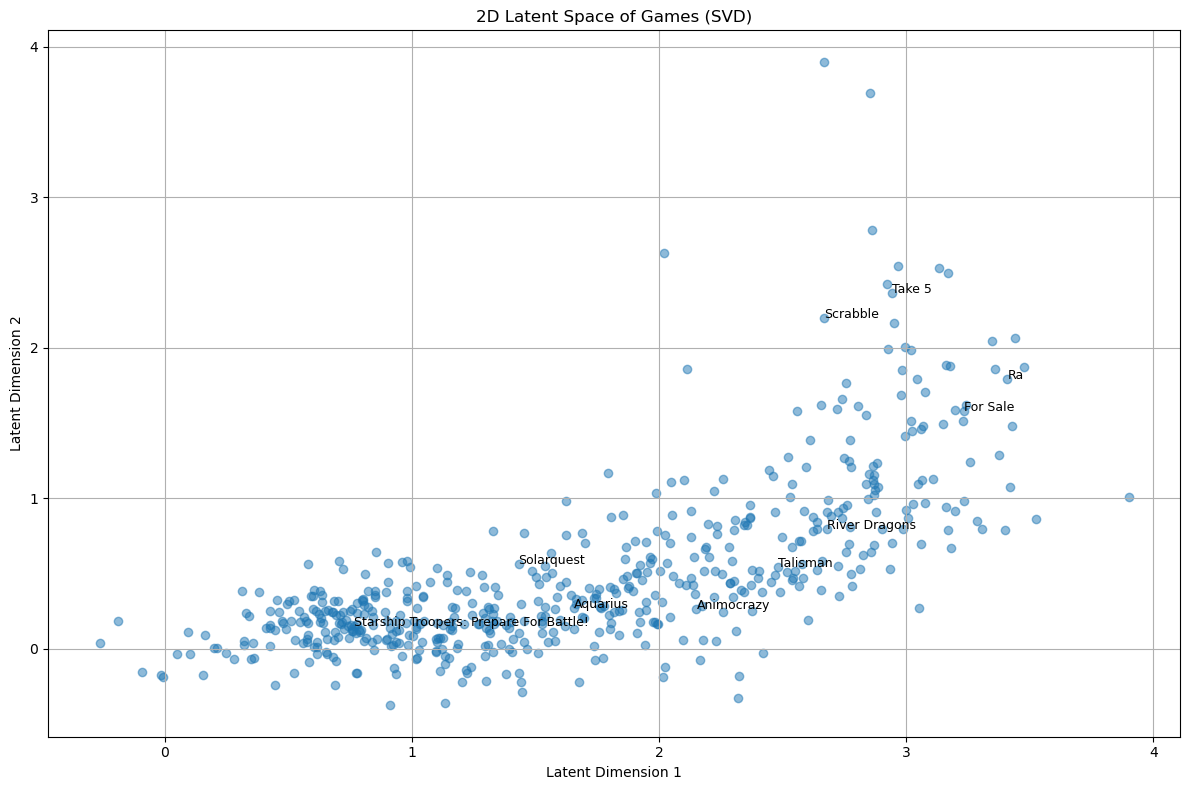

In [ ]:
# Train SVD with 2D latent space
svd_2d = SVD(n_factors=2, lr_all=0.005, reg_all=0.1, biased = False)
svd_2d.fit(trainset)

# Get inner and raw item IDs
item_inner_ids = list(trainset.all_items())
item_raw_ids = [trainset.to_raw_iid(inner_id) for inner_id in item_inner_ids]

# Get game names for raw IDs
item_names = [games.loc[games['id'] == raw_id, 'name'].values[0] for raw_id in item_raw_ids]

# Extract 2D item latent factors
item_factors_2d = np.array([svd_2d.qi[inner_id] for inner_id in item_inner_ids])

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(item_factors_2d[:, 0], item_factors_2d[:, 1], alpha=0.5)

# Label a sample of the points
for i, name in enumerate(item_names[:10]):  # Adjust number to control clutter
    plt.text(item_factors_2d[i, 0], item_factors_2d[i, 1], name, fontsize=9)

plt.title("2D Latent Space of Games (SVD)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

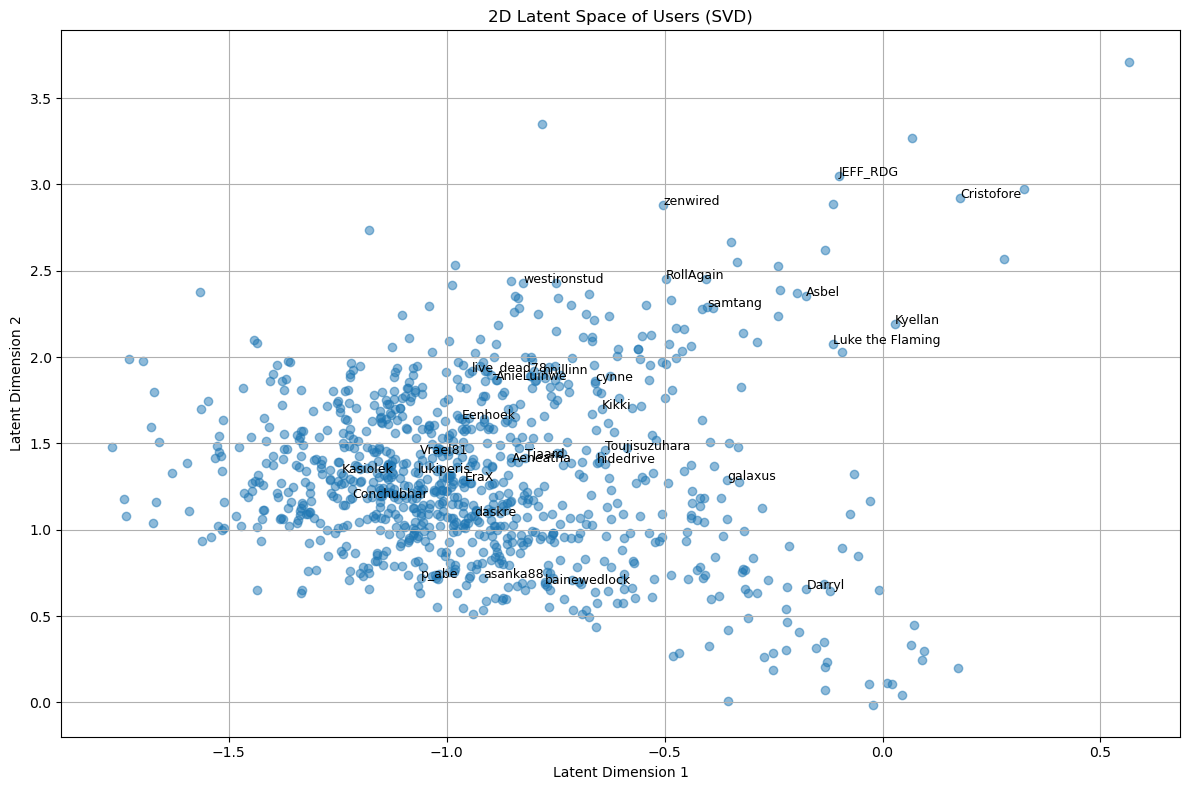

In [ ]:
# Train SVD with 2D latent space
svd_2d = SVD(n_factors=2, lr_all=0.005, reg_all=0.1, biased = False)
svd_2d.fit(trainset)

# Get all inner user IDs
user_inner_ids = list(trainset.all_users())
user_raw_ids = [trainset.to_raw_uid(inner_id) for inner_id in user_inner_ids]

# Extract 2D user latent factors
user_factors_2d = np.array([svd_2d.pu[inner_id] for inner_id in user_inner_ids])

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(user_factors_2d[:, 0], user_factors_2d[:, 1], alpha=0.5)

# Label a few users (e.g. first 30)
for i, user_id in enumerate(user_raw_ids[:30]):
    plt.text(user_factors_2d[i, 0], user_factors_2d[i, 1], user_id, fontsize=9)

plt.title("2D Latent Space of Users (SVD)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()


The users with more ratings are outliers

In [ ]:
reviews[reviews['user'] == 'Cristofore']

,Unnamed: 0,user,rating,comment,ID,name
137513,1374717,Cristofore,7.0,NaN,822,Carcassonne
304786,2706424,Cristofore,6.0,NaN,478,Citadels
335072,3152403,Cristofore,8.0,NaN,50,Lost Cities
427140,4053988,Cristofore,9.0,NaN,171,Chess
564336,5591608,Cristofore,8.0,NaN,93,El Grande
...,...,...,...,...,...,...
1821771,24513203,Cristofore,5.0,NaN,1522,Get Out
1823623,24554923,Cristofore,8.0,NaN,308,Santa Fe
1825448,24582048,Cristofore,6.0,NaN,577,Parts Unknown
1827013,24614071,Cristofore,5.0,NaN,1566,Simply Cosmic


In [ ]:
best_model = SVD(n_factors=100, lr_all=0.005, reg_all=0.02, biased = True)
best_model.fit(trainset)

# Save SVD model
with open("svd_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

user = 'jbourgel'

# Games user has already rated
rated_game_ids = reviews[reviews["user"] == user]["ID"].unique()

# All possible game ids
all_game_ids = games["id"].unique()

# Filter out the ones already rated
unseen_game_ids = [gid for gid in all_game_ids if gid not in rated_game_ids]

# Predict ratings for the unseen games
predictions_user = [(gid, best_model.predict(user, gid).est) for gid in unseen_game_ids]

# Sort by predicted rating
top_k = 10
top_predictions = sorted(predictions_user, key=lambda x: x[1], reverse=True)[:top_k]

# Get game info from the original games DataFrame
top_game_ids = [pred[0] for pred in top_predictions]
recommended_games = games[games["id"].isin(top_game_ids)][["id", "name", "rating"]]
print("\nTop Recommended Games:")
print(recommended_games.reset_index(drop=True))

In [ ]:
# Get predictions on test set
predictions = best_model.test(testset)

# Calculate performance metrics
print("Evaluation Metrics:")
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

In [ ]:
precision, recall = precision_recall_at_k(predictions, k=10)
print(f"Precision@10: {precision:.4f}")
print(f"Recall@10: {recall:.4f}")

Now we represent the projection of the latent space of the games created with the SVD model. Only the 30 first games will have the id label to ensure readability. The games that are close to each other have similar latent factors.

In [ ]:
# Get game factors
item_ids = trainset.all_items()
item_inner_ids = list(item_ids)
item_raw_ids = [trainset.to_raw_iid(inner_id) for inner_id in item_inner_ids]
item_factors = np.array([best_model.qi[inner_id] for inner_id in item_inner_ids])

# Reduce to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity = 15)
item_2d = tsne.fit_transform(item_factors)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(item_2d[:, 0], item_2d[:, 1], alpha=0.6)
for i, item_id in enumerate(item_raw_ids[:30]):  # label a few
    plt.text(item_2d[i, 0], item_2d[i, 1], item_id, fontsize=9)
plt.title("t-SNE Visualization of Game Embeddings (SVD)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

The following plot represents the user-item matrix of 10 users and 10 games. We can see that the games with predicted low ratings will propagate over users and the same with high ratings.

In [ ]:
import seaborn as sns

# Pick a sample of users and items
sample_users = list(trainset.all_users())[:10]
sample_items = list(trainset.all_items())[:10]

matrix = np.zeros((len(sample_users), len(sample_items)))
for i, uid in enumerate(sample_users):
    for j, iid in enumerate(sample_items):
        matrix[i, j] = best_model.predict(trainset.to_raw_uid(uid), trainset.to_raw_iid(iid)).est

sns.heatmap(matrix, annot=True, fmt=".1f", cmap="coolwarm")
plt.xlabel("Games")
plt.ylabel("Users")
plt.title("Predicted Ratings Heatmap (Sample)")
plt.show()

## Dashboard

In [ ]:
# CODE TO MAKE SURPRISE LIBRARY WORK
!pip uninstall -y numpy scikit-surprise tensorflow numba
!pip install numpy==1.26.4
!pip install numba==0.60.0
!pip install scikit-surprise
!pip install tensorflow==2.18.0

In [ ]:
!pip install jupyter-dash

In [ ]:
import base64
import pickle
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from gensim import corpora, models
from dash import Dash, html, dcc, Input, Output, callback_context, State
from dash.exceptions import PreventUpdate
from dash.dependencies import ALL
from wordcloud import WordCloud
from io import BytesIO
from surprise import KNNWithMeans, Dataset, Reader
from surprise import SVD

# ------------------------------
# Dataset definition
# ------------------------------
filename = "boardgames_3000_clean_dual_tone_glove_cluster_popularity.csv"
games = pd.read_csv(filename, sep=";")
games["glove_vector"] = games["glove_vector"].apply(lambda x: np.fromstring(str(x).strip("[]"), sep=" "))
reviews = pd.read_csv("filtered_reviews.csv", sep=";")

# ------------------------------
# TF-IDF
# ------------------------------
def prepare_tfidf_matrix(games):
  # Tokenize
  tokenized_descr = [clean_description.split() for clean_description in games["clean_description"]]

  # Dictionary and corpus
  dictionary = corpora.Dictionary(tokenized_descr)
  bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_descr]

  # TF-IDF corpus
  tfidf = models.TfidfModel(bow_corpus)
  tfidf_corpus = tfidf[bow_corpus]
  num_docs = len(tfidf_corpus)
  num_terms = len(dictionary)

  # Create empty matrix
  X_tfidf_gensim = np.zeros((num_docs, num_terms))

  # Fill it with TF-IDF scores
  for doc_idx, doc in enumerate(tfidf_corpus):
      for term_id, tfidf_score in doc:
          X_tfidf_gensim[doc_idx, term_id] = tfidf_score

  return dictionary, bow_corpus, tfidf_corpus, X_tfidf_gensim

def plot_tfidf_summary(dictionary, X_tfidf, top_n=25):
    # Average and total scores
    avg_scores = X_tfidf.mean(axis=0)
    tfidf_term_scores = X_tfidf.sum(axis=0)

    # Bar plot: top average scores
    top_indices = avg_scores.argsort()[::-1][:top_n]
    top_terms = [dictionary[i] for i in top_indices]
    top_scores = avg_scores[top_indices]

    bar_fig = go.Figure(go.Bar(
        x=top_terms,
        y=top_scores,
        marker_color='indigo'
    ))
    bar_fig.update_layout(
        xaxis_title="Term",
        yaxis_title="Average TF-IDF",
        xaxis_tickangle=-45
    )

    # Word cloud
    word_freq = {dictionary[i]: tfidf_term_scores[i] for i in range(len(dictionary))}

    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='viridis',
        max_words=200
    ).generate_from_frequencies(word_freq)

    # Convert to base64 image string for Dash
    img = BytesIO()
    wordcloud.to_image().save(img, format='PNG')
    img.seek(0)
    encoded_image = base64.b64encode(img.read()).decode()

    return bar_fig, encoded_image

dictionary, bow_corpus, tfidf_corpus, X_tfidf = prepare_tfidf_matrix(games)
_, encoded_image = plot_tfidf_summary(dictionary, X_tfidf)


# ------------------------------
# Popular Games
# ------------------------------
def get_diverse_popular_games(games, top_k=10):
    recommended_games = []

    # Iterate over clusters to get popular games from each cluster
    for cluster in range(games["description_cluster20"].nunique()):
        # Get games in the cluster
        games_cluster = games[games["description_cluster20"] == cluster]

        # Sort by popularity
        games_cluster = games_cluster.sort_values("popularity_score", ascending=False)

        # Select the top 1 game from each cluster to ensure diversity
        top_game = games_cluster.head(1)
        recommended_games.append(top_game)

    # Combine all recommended games and sort by popularity score
    recommended_games = pd.concat(recommended_games)
    recommended_games = recommended_games.sort_values("popularity_score", ascending=False).head(top_k)

    explanations = []
    for _, row in recommended_games.iterrows():
        cluster = row["description_cluster20"]
        rating = round(row["avg_rating"], 2)
        num = int(row["num_ratings"])

        explanation = (f"This game is highly rated ({rating}/10 from {num} users)")
        explanations.append(explanation)

    recommended_games["explanation"] = explanations

    return recommended_games[["name", "clean_description", "avg_rating", "num_ratings", "popularity_score", "explanation"]]

# ------------------------------
# Content-Based System (MMR)
# ------------------------------
def mmr(user_profile, candidate_vectors, candidate_ids, lambda_param=0.7, top_k=10):
    selected = []
    selected_ids = []
    candidate_indices = list(range(len(candidate_vectors)))

    similarities_to_user = cosine_similarity(candidate_vectors, [user_profile]).flatten()
    similarity_matrix = cosine_similarity(candidate_vectors)

    for _ in range(top_k):
        mmr_scores = []
        for idx in candidate_indices:
            if not selected:
                diversity_penalty = 0
            else:
                diversity_penalty = max(similarity_matrix[idx][j] for j in selected)

            mmr_score = lambda_param * similarities_to_user[idx] - (1 - lambda_param) * diversity_penalty
            mmr_scores.append((idx, mmr_score))

        selected_idx, _ = max(mmr_scores, key=lambda x: x[1])
        selected.append(selected_idx)
        selected_ids.append(candidate_ids[selected_idx])
        candidate_indices.remove(selected_idx)

    return selected_ids

def visualize_mmr(user_vector, candidate_vectors, candidate_ids, game_names, lambda_param=0.7, top_k=10):
    # Get top-k by similarity
    relevance = cosine_similarity(candidate_vectors, [user_vector]).flatten()
    top_k_indices = relevance.argsort()[::-1][:top_k]
    top_k_ids = [candidate_ids[i] for i in top_k_indices]

    # Get top-k using MMR
    mmr_ids = mmr(user_vector, candidate_vectors, candidate_ids, lambda_param, top_k)

    # Reduce dimensions for plotting
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(np.vstack([user_vector, candidate_vectors]))
    user_p = reduced[0]
    candidates_p = reduced[1:]

    plt.figure(figsize=(10, 7))
    plt.scatter(candidates_p[:, 0], candidates_p[:, 1], c='lightgray', label="All Candidates", alpha=0.5)

    # Plot user profile
    plt.scatter(user_p[0], user_p[1], c='blue', label="User Profile", marker='X', s=100)

    # Plot top-k by similarity
    for idx in top_k_indices:
        plt.scatter(candidates_p[idx, 0], candidates_p[idx, 1], c='green', label="Top-k Similarity" if idx == top_k_indices[0] else "", edgecolors='black')
        plt.text(candidates_p[idx, 0], candidates_p[idx, 1], game_names[candidate_ids[idx]], fontsize=8, color='darkgreen')

    # Plot MMR-selected games
    for mmr_id in mmr_ids:
        i = candidate_ids.index(mmr_id)
        plt.scatter(candidates_p[i, 0], candidates_p[i, 1], c='orange', label="Top-k MMR" if mmr_id == mmr_ids[0] else "", edgecolors='black')
        plt.text(candidates_p[i, 0], candidates_p[i, 1], game_names[mmr_id], fontsize=8, color='darkorange')

    plt.legend()
    plt.title(f"MMR vs Top-k Similarity (λ = {lambda_param})")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)

    # Instead of plt.show(), convert to base64
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close()
    buf.seek(0)
    return base64.b64encode(buf.read()).decode()

def recommend_content_based_mmr(user_name, games, reviews, top_k=10, testing=False, max_playingtime=None, min_age=None, minplayers=None, maxplayers=None, min_rating=6, plot=False):
    # Filter games based on user preferences
    filtered_games = games.copy()

    if max_playingtime is not None:
        filtered_games = filtered_games[filtered_games["playingtime"] <= max_playingtime]
    if min_age is not None:
        filtered_games = filtered_games[filtered_games["minage"] >= min_age]
    if minplayers is not None:
        filtered_games = filtered_games[filtered_games["minplayers"] <= minplayers]
    if maxplayers is not None:
        filtered_games = filtered_games[filtered_games["maxplayers"] >= maxplayers]
    if min_rating is not None:
        filtered_games = filtered_games[filtered_games["rating"] >= min_rating]

    if filtered_games.empty:
        print("No games match the provided filters.")
        return

    # Get games the user liked
    liked_game_ids = reviews[(reviews["user"] == user_name) & (reviews["rating"] >= 6)]
    liked_vectors = liked_game_ids.merge(games[["id", "glove_vector"]], left_on="ID", right_on="id")

    if liked_vectors.empty:
        print("Not enough liked games with vectors to build a profile.")
        return

    # Build user profile (weighted average)
    ratings = liked_vectors["rating"].values
    weights = ratings / ratings.max()
    vectors = np.vstack(liked_vectors["glove_vector"])
    user_profile = np.average(vectors, axis=0, weights=weights)

    if not testing:
        # Remove already liked games from recommendations
        unseen_mask = ~filtered_games["id"].isin(liked_game_ids["ID"])
        filtered_games = filtered_games[unseen_mask]

    if filtered_games.empty:
        print("No new games to recommend after filtering out liked ones.")
        return

    # Prepare data for MMR
    game_vectors = np.vstack(filtered_games["glove_vector"].values)
    similarities = cosine_similarity(game_vectors, [user_profile]).flatten()

    # Apply MMR for diversity
    selected_ids = mmr(user_profile, game_vectors, filtered_games["id"].tolist(), lambda_param=0.7, top_k=top_k)
    recommended_games = filtered_games[filtered_games["id"].isin(selected_ids)].copy()

    # Add similarity score for interpretability
    recommended_games["similarity"] = similarities[[filtered_games["id"].tolist().index(i) for i in selected_ids]]

    # Generate personalized explanations with vibe and emotion
    explanations = []
    for game_id in selected_ids:
        # Find the most similar liked game
        similarities_to_liked_games = cosine_similarity([games.loc[games["id"] == game_id, "glove_vector"].values[0]], liked_vectors["glove_vector"].tolist()).flatten()
        most_similar_game_idx = np.argmax(similarities_to_liked_games)
        most_similar_game_id = liked_game_ids.iloc[most_similar_game_idx]["ID"]
        most_similar_game_name = games.loc[games["id"] == most_similar_game_id, "name"].values[0]
        most_similar_rating = liked_game_ids.iloc[most_similar_game_idx]["rating"]

        # Get predicted vibe and emotion for the recommended game
        predicted_vibe = games.loc[games["id"] == game_id, "predicted_vibe"].values[0]
        predicted_emotion = games.loc[games["id"] == game_id, "predicted_emotion"].values[0]

        # Generate the explanation
        explanation = (
            f"I recommend this game because you liked '{most_similar_game_name}' "
            f"(you rated it {most_similar_rating}/10). "
            f"This game has a '{predicted_emotion}' feeling and is '{predicted_vibe}'."
        )
        explanations.append(explanation)

    recommended_games["explanation"] = explanations

    mmr_plot_encoded = None
    if plot:
        mmr_plot_encoded = visualize_mmr(user_profile, game_vectors, filtered_games["id"].tolist(), dict(zip(games["id"], games["name"])), lambda_param=0.7, top_k=top_k)

    return recommended_games[["name", "rating", "id", "similarity", "explanation"]], mmr_plot_encoded

# ------------------------------
# Hybrid Content-Based
# ------------------------------
def predict_all_ratings(user_name, games_df, reviews_df, k=10):
    # Get user-rated games and their vectors
    user_reviews = reviews_df[reviews_df["user"] == user_name]
    if user_reviews.empty:
        return "No reviews found for this user."

    user_games = user_reviews.merge(games_df[["id", "glove_vector"]], left_on="ID", right_on="id")
    if user_games.empty:
        return "User has rated games with no vector information."

    rated_vectors = np.vstack(user_games["glove_vector"])
    rated_ratings = user_games["rating"].values
    rated_names = user_games["name"].tolist()

    # Games not yet rated by user
    unseen_games = games_df[~games_df["id"].isin(user_games["id"])].copy()
    if unseen_games.empty:
        return "No unseen games to predict ratings for."

    predicted_ratings = []

    for _, game in unseen_games.iterrows():
        target_vector = game["glove_vector"]

        # Cosine similarity with all user-rated games
        similarities = cosine_similarity(rated_vectors, [target_vector]).flatten()
        similarities = np.maximum(similarities, 0)

        # Select top-k most similar games
        if len(similarities) < k:
            k_adj = len(similarities)
        else:
            k_adj = k

        top_k_idx = np.argsort(similarities)[-k_adj:]
        top_similarities = similarities[top_k_idx]
        top_ratings = rated_ratings[top_k_idx]
        top_game_names = [rated_names[i] for i in top_k_idx]

        if top_similarities.sum() == 0:
            pred_rating = np.nan
            explanation = "No sufficiently similar games found."
        else:
            pred_rating = np.average(top_ratings, weights=top_similarities)
            # Build explanation
            if len(top_game_names) == 1:
                explanation = f"Because you liked **{top_game_names[0]}**, and this game is similar to it."
            elif len(top_game_names) == 2:
                explanation = f"Because you liked **{top_game_names[0]}** and **{top_game_names[1]}**, and this game is similar to both."
            else:
                explanation = f"Because you liked games like **{top_game_names[0]}**, **{top_game_names[1]}**, and others."

        predicted_ratings.append((game["id"], game["name"], round(pred_rating, 2) if not np.isnan(pred_rating) else None, explanation))

    # Return as a DataFrame
    pred_df = pd.DataFrame(predicted_ratings, columns=["id", "name", "predicted_rating", "explanation"])
    pred_df = pred_df.sort_values(by="predicted_rating", ascending=False)

    return pred_df

# ------------------------------
# Collaborative functions
# ------------------------------
def recommend_with_knn(user_name, games_df, reviews_df, top_k=10):
    # Load KNNWithMeans model
    with open("knn_model.pkl", "rb") as f:
        model = pickle.load(f)

    # Get games the user has not rated
    rated_ids = reviews_df[reviews_df["user"] == user_name]["ID"].unique()
    unseen_ids = [gid for gid in games_df["id"].unique() if gid not in rated_ids]

    # Predict ratings
    predictions = [(gid, model.predict(user_name, gid).est) for gid in unseen_ids]
    top_preds = sorted(predictions, key=lambda x: x[1], reverse=True)[:top_k]

    # Retrieve game info
    top_game_ids = [gid for gid, _ in top_preds]
    recommended = games_df[games_df["id"].isin(top_game_ids)][["name", "rating", "id"]].copy()
    recommended["predicted_rating"] = [round(r, 2) for _, r in top_preds]

    return recommended.sort_values("predicted_rating", ascending=False)

def recommend_with_svd(user_name, games_df, reviews_df, top_k=10):
    # Load model
    with open("svd_model.pkl", "rb") as f:
        model = pickle.load(f)

    # Get games the user has not rated
    rated_ids = reviews_df[reviews_df["user"] == user_name]["ID"].unique()
    unseen_ids = [gid for gid in games_df["id"].unique() if gid not in rated_ids]

    # Predict ratings
    predictions = [(gid, model.predict(user_name, gid).est) for gid in unseen_ids]
    top_preds = sorted(predictions, key=lambda x: x[1], reverse=True)[:top_k]

    # Retrieve game info
    top_game_ids = [gid for gid, _ in top_preds]
    recommended = games_df[games_df["id"].isin(top_game_ids)][["name", "rating", "id"]].copy()
    recommended["predicted_rating"] = [round(r, 2) for _, r in top_preds]

    return recommended.sort_values("predicted_rating", ascending=False)

# ------------------------------
# Dash App
# ------------------------------
app = Dash(__name__, suppress_callback_exceptions=True)

# --- Global Styles ---
app.index_string = '''
<!DOCTYPE html>
<html>
    <head>
        {%metas%}
        <title>Board Game Recommender</title>
        {%favicon%}
        {%css%}
        <link href="https://fonts.googleapis.com/css2?family=Inter:wght@400;600&display=swap" rel="stylesheet">
        <style>
            body {
                font-family: 'Inter', sans-serif;
                background-color: #f8f9fa;
                margin: 0;
                padding: 0;
            }
            .landing-container {
                display: flex;
                flex-direction: column;
                align-items: center;
                justify-content: center;
                height: 100vh;
                text-align: center;
            }
            .landing-container h1 {
                font-size: 3rem;
                margin-bottom: 0.5em;
            }
            .landing-container p {
                font-size: 1.2rem;
                color: #555;
                margin-bottom: 2em;
            }
            .button-row {
                display: flex;
                gap: 1.5em;
                flex-wrap: wrap;
                justify-content: center;
            }
            .start-button {
                font-size: 1rem;
                padding: 0.75em 1.5em;
                border: none;
                border-radius: 8px;
                background-color: #007BFF;
                color: white;
                cursor: pointer;
                transition: background-color 0.3s ease;
                min-width: 180px;
            }
            .start-button:hover {
                background-color: #0056b3;
            }
            .back-button-container {
                display: flex;
                justify-content: center;
                margin-top: 3em;
            }
            .back-button {
                font-size: 1rem;
                padding: 0.75em 1.5em;
                border: none;
                border-radius: 8px;
                background-color: #6c757d;
                color: white;
                cursor: pointer;
                transition: background-color 0.3s ease;
                min-width: 180px;
            }
            .back-button:hover {
                background-color: #5a6268;
            }
        </style>
    </head>
    <body>
        {%app_entry%}
        <footer>
            {%config%}
            {%scripts%}
            {%renderer%}
        </footer>
    </body>
</html>
'''

# --- Landing Layout ---
landing_layout = html.Div(className="landing-container", children=[
    html.H1("🎲 Welcome to the Board Game Recommender"),
    html.P("Discover games tailored to your preferences."),
    html.Div(className="button-row", children=[
        html.A(html.Button("Explore Dataset", className="start-button"), href="/exploration"),
        html.A(html.Button("Start Recommending", className="start-button"), href="/recommender")
    ])
])

# --- Recommender Layout ---
recommender_layout = html.Div(style={
    'display': 'flex',
    'flexDirection': 'column',
    'alignItems': 'center',
    'justifyContent': 'center',
    'padding': '5vh 2rem',
    'textAlign': 'center'
}, children=[
    html.Div("🕵️‍♂️", style={'fontSize': '5rem', 'marginBottom': '0.5rem'}),
    html.H2("Who are you?"),
    html.P("Enter your username to continue"),
    dcc.Input(
        id='user-name-input',
        type='text',
        placeholder='e.g. boardgamefan99',
        debounce=True,
        style={
            'padding': '0.6rem 1rem',
            'fontSize': '1rem',
            'borderRadius': '8px',
            'border': '1px solid #ccc',
            'width': '300px',
            'marginTop': '1rem'
        }
    ),

    html.Div(id='game-rating-inputs', style={'width': '100%', 'maxWidth': '600px'}),
    html.Div(style={'display': 'flex', 'gap': '1rem', 'marginTop': '1.5rem'}, children=[
        html.A(html.Button("← Go Back", className="back-button"), href="/"),
        html.Button("Continue", id='user-continue-button', n_clicks=0, style={
            'padding': '0.6rem 1.5rem',
            'fontSize': '1rem',
            'border': 'none',
            'borderRadius': '8px',
            'backgroundColor': '#007BFF',
            'color': 'white',
            'cursor': 'pointer'
        })
    ]),
    html.Div(id='user-error', style={'color': 'red', 'marginTop': '1rem'})
])

# --- Data Exploration Layout ---
exploration_layout = html.Div([
    html.H2("📊 Dataset Overview"),

    html.H4("ℹ️ TMI but..."),
    html.P([
        "Our dataset is self-collected and based on data from ",
        html.A("BoardGameGeek", href="https://boardgamegeek.com/", target="_blank"),
        ", the world’s largest online board game database and community. It contains",
        f" {len(games):,} board games including ratings, player requirements, age guidelines, and more."
    ]),
    html.P("BoardGameGeek hosts ratings, reviews, descriptions, and play guides for thousands of games, powered by contributions from over 2 million registered users. We could say it’s a go-to hub for board game enthusiasts around the world."),

    html.Br(),
    html.H4("🔍 TF-IDF Summary"),
    html.P("Ever wondered which words make board games truly stand out? The chart and cloud below show the most distinctive terms across all game descriptions, calculated using a method called TF-IDF. The higher the score, the more unique and important a word is to describing those games. Try adjusting the slider to explore the top keywords!"),

    html.Div(style={
        'backgroundColor': '#e7f1fb',
        'border': '1px solid #c3d9ec',
        'borderRadius': '12px',
        'padding': '1.5rem',
        'marginTop': '1rem',
        'marginBottom': '2rem',
        'boxShadow': '0 2px 5px rgba(0,0,0,0.05)'
    }, children=[
        html.Label("Select number of top terms:"),
        dcc.Slider(
            id='top-k-slider',
            min=5,
            max=50,
            step=1,
            value=25,
            marks={i: str(i) for i in range(5, 51, 5)},
            tooltip={"placement": "bottom", "always_visible": True}
        ),
        html.Br(),

        html.Div(style={'display': 'flex', 'justifyContent': 'space-between', 'gap': '2em'}, children=[

            # Left: bar chart
            html.Div(style={'flex': '1'}, children=[
                dcc.Graph(id='tfidf-bar-chart', style={'height': '230px'})
            ]),

            # Right: word cloud
            html.Div(style={'flex': '1', 'textAlign': 'center'}, children=[
                html.Img(id='tfidf-wordcloud',
                        src='data:image/png;base64,{}'.format(encoded_image),
                        style={'width': '100%', 'maxWidth': '100%'})
            ])
        ])
    ]),

    html.Br(),
    html.H4("🧠 Topic Distribution (LDA)"),
    html.P("Explore how topics are distributed across the board game descriptions. This interactive map lets you hover over topics, see top keywords, and better understand how the model organizes the data."),
    html.Div(style={
        'backgroundColor': '#e7f1fb',
        'border': '1px solid #c3d9ec',
        'borderRadius': '12px',
        'padding': '1.5rem',
        'marginTop': '1rem',
        'marginBottom': '2rem',
        'boxShadow': '0 2px 5px rgba(0,0,0,0.05)'
    }, children=[
        html.Iframe(
            src="/assets/lda_vis.html",
            style={
                "width": "100%",
                "height": "600px",
                "border": "none",
                "borderRadius": "12px"
            }
        )
    ]),

    html.Div(className="back-button-container", children=[
        html.A(html.Button("← Go Back", className="back-button"), href="/")
    ])
])

# --- Register User Layout ---
register_user_layout = html.Div(style={
    'display': 'flex',
    'flexDirection': 'column',
    'alignItems': 'center',
    'padding': '5vh 2rem',
    'textAlign': 'center'
}, children=[
    html.H2("Oops! Looks like you are new here...please register!"),

    # Username row
    html.Div(style={'display': 'flex', 'alignItems': 'center', 'gap': '1rem', 'marginBottom': '1.5rem'}, children=[
        html.Label("Username:", style={'fontWeight': 'bold', 'whiteSpace': 'nowrap'}),
        dcc.Input(
            id='new-username-input',
            type='text',
            placeholder='e.g. boardgamefan123',
            style={
                'padding': '0.6rem 1rem',
                'fontSize': '1rem',
                'borderRadius': '8px',
                'border': '1px solid #ccc',
                'width': '300px'
            }
        )
    ]),

    # Game selection row
    html.Div(style={'display': 'flex', 'alignItems': 'center', 'gap': '1rem', 'marginBottom': '1.5rem'}, children=[
        html.Label("Search for 5 games you like:", style={'fontWeight': 'bold', 'whiteSpace': 'nowrap'}),
        dcc.Dropdown(
            id='game-selection-dropdown',
            options=[
                {'label': row['name'], 'value': row['id']}
                for _, row in games.sort_values('name').iterrows()
            ],
            multi=True,
            placeholder="Start typing to find games…",
            style={'width': '500px'}
        )
    ]),

    # Rating sliders will appear here
    html.Div(id='game-rating-inputs', style={
        'width': '100%',
        'maxWidth': '600px',
        'marginBottom': '2rem'
    }),

    # Buttons
    html.Div(style={'display': 'flex', 'gap': '1rem'}, children=[
        html.A(html.Button("← Go Back", className="back-button"), href="/new-user-choice"),
        html.Button("Register", id="register-button", n_clicks=0, style={
            'padding': '0.6rem 1.5rem',
            'fontSize': '1rem',
            'border': 'none',
            'borderRadius': '8px',
            'backgroundColor': '#007BFF',
            'color': 'white',
            'cursor': 'pointer'
        })
    ]),

    html.Div(id='register-error', style={'color': 'red', 'marginTop': '1rem'})
])

# --- Recommendation Options Layout ---
recommendation_options_layout = html.Div(style={
    'display': 'flex',
    'flexDirection': 'column',
    'alignItems': 'center',
    'padding': '5vh 2rem',
    'textAlign': 'center'
}, children=[
    html.H2("🧠 Choose a Recommendation Strategy"),
    html.P("Select an algorithm below to get your personalized board game recommendations."),

    html.Div(style={'display': 'flex', 'gap': '1.5rem', 'marginTop': '2rem'}, children=[
        html.Button("🔍 Content-Based Filtering (MMR)", id='algo-content', className='start-button'),
        html.Button("🤝 Collaborative Filtering", id='algo-collab', className='start-button'),
        html.Button("🧪 Hybrid Approach", id='algo-hybrid', className='start-button')
    ]),

    html.Div(className="back-button-container", children=[
        html.A(html.Button("← Go Back", className="back-button"), href="/recommender")
    ])
])

# --- New User Choice Layout ---
new_user_choice_layout = html.Div(style={
    'display': 'flex',
    'flexDirection': 'column',
    'alignItems': 'center',
    'justifyContent': 'center',
    'padding': '8vh 2rem',
    'textAlign': 'center'
}, children=[
    html.Div("✨", style={'fontSize': '4rem', 'marginBottom': '0.5rem'}),
    html.H2("Looks like it's your first time here!"),
    html.P("Would you like to create a profile for personalized recommendations or just see what's popular?"),

    html.Div(style={'display': 'flex', 'gap': '2rem', 'marginTop': '2rem'}, children=[
        html.Button("🎯 Create a Profile", id="go-to-register", n_clicks=0, style={
            'padding': '1rem 2rem',
            'fontSize': '1.1rem',
            'border': 'none',
            'borderRadius': '10px',
            'backgroundColor': '#007BFF',
            'color': 'white',
            'cursor': 'pointer',
            'minWidth': '220px'
        }),
        html.Button("🔥 Show Popular Games", id="go-to-popular", n_clicks=0, style={
            'padding': '1rem 2rem',
            'fontSize': '1.1rem',
            'border': 'none',
            'borderRadius': '10px',
            'backgroundColor': '#28a745',
            'color': 'white',
            'cursor': 'pointer',
            'minWidth': '220px'
        })
    ]),

    html.Div(className="back-button-container", children=[
        html.A(html.Button("← Go Back", className="back-button"), href="/recommender")
    ])
])

# --- Popular Games Layout ---
popular_games_layout = html.Div([
    html.H2("🔥 Popular Board Games"),
    html.Div([
        html.Label("Select how many games to show:", style={'fontWeight': 'bold'}),
        dcc.Slider(
            id="top-n-slider",
            min=5,
            max=15,
            step=1,
            value=10,
            marks={i: str(i) for i in range(5, 16)},
            tooltip={"placement": "bottom", "always_visible": True},
            updatemode="drag"
        )
    ], style={'width': '100%', 'padding': '1rem 3rem', 'marginBottom': '2rem'}),
    html.Div(id="popular-games-output"),
    html.Div(className="back-button-container", children=[
        html.A(html.Button("← Go Back", className="back-button"), href="/new-user-choice")
    ])
])

# --- Content-Based MMR Layout ---
content_mmr_layout = html.Div(style={
    'display': 'flex',
    'flexDirection': 'column',
    'alignItems': 'center',
    'padding': '5vh 2rem',
    'textAlign': 'center'
}, children=[

    html.H2("🎯 Content-Based MMR Recommender"),
    html.P("Customize the parameters below to get personalized and diverse game recommendations."),

    html.Div([

        html.Div([
            html.Label("🎲 Max Playing Time (minutes):"),
            dcc.Slider(
                id="input-max-playingtime",
                min=10, max=300, step=10, value=60,
                marks={i: str(i) for i in range(30, 301, 30)},
                tooltip={"placement": "bottom", "always_visible": True}
            )
        ], style={"width": "100%", "maxWidth": "600px", "marginBottom": "1.5rem"}),

        html.Div([
            html.Label("👶 Minimum Age:"),
            dcc.Slider(
                id="input-min-age",
                min=3, max=18, step=1, value=10,
                marks={i: str(i) for i in range(3, 19, 3)},
                tooltip={"placement": "bottom", "always_visible": True}
            )
        ], style={"width": "100%", "maxWidth": "600px", "marginBottom": "1.5rem"}),

        html.Div([
            html.Label("👥 Minimum Players:"),
            dcc.Slider(
                id="input-min-players",
                min=1, max=10, step=1, value=2,
                marks={i: str(i) for i in range(1, 11)},
                tooltip={"placement": "bottom", "always_visible": True}
            )
        ], style={"width": "100%", "maxWidth": "600px", "marginBottom": "1.5rem"}),

        html.Div([
            html.Label("👥 Maximum Players:"),
            dcc.Slider(
                id="input-max-players",
                min=1, max=20, step=1, value=4,
                marks={i: str(i) for i in range(2, 21, 2)},
                tooltip={"placement": "bottom", "always_visible": True}
            )
        ], style={"width": "100%", "maxWidth": "600px", "marginBottom": "1.5rem"}),

        html.Div([
            html.Label("⭐ Minimum Rating:"),
            dcc.Slider(
                id="input-min-rating",
                min=1, max=10, step=1, value=6,
                marks={i: str(i) for i in range(1, 11)},
                tooltip={"placement": "bottom", "always_visible": True}
            )
        ], style={"width": "100%", "maxWidth": "600px", "marginBottom": "1.5rem"}),

        html.Div([
            html.Label("🔝 Number of Recommendations (Top-K):"),
            dcc.Slider(
                id="input-top-k",
                min=3, max=20, step=1, value=10,
                marks={i: str(i) for i in range(3, 21)},
                tooltip={"placement": "bottom", "always_visible": True}
            )
        ], style={"width": "100%", "maxWidth": "600px", "marginBottom": "1.5rem"}),

        html.Div([
            html.Label("⚖️ MMR Lambda (Diversity vs Relevance):"),
            dcc.Slider(
                id="input-lambda-param",
                min=0.0, max=1.0, step=0.05, value=0.7,
                marks={i / 10: str(i / 10) for i in range(0, 11)},
                tooltip={"placement": "bottom", "always_visible": True}
            )
        ], style={"width": "100%", "maxWidth": "600px", "marginBottom": "2rem"}),

        html.Button("🚀 Run Recommender", id="run-mmr-recommender", n_clicks=0, className="start-button")

    ], style={"width": "100%", "maxWidth": "650px"}),

    html.Hr(style={"margin": "3rem 0", "width": "100%"}),

    html.Div(id="cb-mmr-recommendation-output", style={"width": "100%", "maxWidth": "800px"}),
    html.Img(id="cb-mmr-plot-output", style={"marginTop": "2rem", "maxWidth": "100%"}),

    html.Div(className="back-button-container", children=[
        html.A(html.Button("← Go Back", className="back-button"), href="/recommendation-options")
    ])
])

# --- Hybrid Content-Based Layout ---
hybrid_layout = html.Div(style={
    'display': 'flex',
    'flexDirection': 'column',
    'alignItems': 'center',
    'padding': '5vh 2rem',
    'textAlign': 'center'
}, children=[

    html.H2("🧪 Hybrid Recommender"),
    html.P("This approach combines content-based filtering with rating prediction using similarity."),

    html.Div(style={"width": "100%", "maxWidth": "650px", "marginBottom": "2rem"}, children=[
        html.Label("🔍 Number of Similar Games to Consider (k):", style={'fontWeight': 'bold'}),
        dcc.Slider(
            id="input-k",
            min=1,
            max=20,
            step=1,
            value=10,
            marks={i: str(i) for i in range(1, 21)},
            tooltip={"placement": "bottom", "always_visible": True}
        )
    ]),

    html.Button("🚀 Run Hybrid Recommender", id="run-hybrid-recommender", n_clicks=0, className="start-button"),

    html.Hr(style={"margin": "3rem 0", "width": "100%"}),

    html.Div(id="hybrid-recommendation-output", style={"width": "100%", "maxWidth": "800px"}),

    html.Div(className="back-button-container", children=[
        html.A(html.Button("← Go Back", className="back-button"), href="/recommendation-options")
    ])
])

# --- Collaborative Filtering Layout ---
collaborative_layout = html.Div(style={
    'display': 'flex',
    'flexDirection': 'column',
    'alignItems': 'center',
    'padding': '5vh 2rem',
    'textAlign': 'center'
}, children=[
    html.H2("🤝 Collaborative Filtering"),
    html.P("Select the method and number of recommendations."),

    html.Div([
        html.Label("📌 Choose a method:"),
        dcc.RadioItems(
            id="collab-method",
            options=[
                {"label": "KNN With Means", "value": "knn"},
                {"label": "SVD", "value": "svd"}
            ],
            value="knn",
            labelStyle={"display": "inline-block", "marginRight": "1rem"}
        )
    ], style={"marginBottom": "2rem"}),

    html.Div([
        html.Label("🔝 Number of Recommendations (Top-K):"),
        dcc.Slider(
            id="collab-top-k",
            min=3, max=20, step=1, value=10,
            marks={i: str(i) for i in range(3, 21)},
            tooltip={"placement": "bottom", "always_visible": True}
        )
    ], style={"width": "100%", "maxWidth": "600px", "marginBottom": "2rem"}),

    html.Button("🚀 Run Collaborative Recommender", id="run-collab-recommender", n_clicks=0, className="start-button"),

    html.Hr(style={"margin": "3rem 0", "width": "100%"}),

    html.Div(id="collab-recommendation-output", style={"width": "100%", "maxWidth": "800px"}),

    html.Div(className="back-button-container", children=[
        html.A(html.Button("← Go Back", className="back-button"), href="/recommendation-options")
    ])
])

# --- App Layout ---
app.layout = html.Div([
    dcc.Location(id='url', refresh=False),
    dcc.Store(id='stored-username', storage_type='session'),
    html.Div(id='page-content')
])

# --- Page Router ---
@app.callback(Output('page-content', 'children'),
              Input('url', 'pathname'))
def display_page(pathname):
    if pathname == "/recommender":
        return recommender_layout
    elif pathname == "/exploration":
        return exploration_layout
    elif pathname == "/register-user":
        return register_user_layout
    elif pathname == "/new-user-choice":
        return new_user_choice_layout
    elif pathname == "/recommendation-options":
        return recommendation_options_layout
    elif pathname == "/popular":
        return popular_games_layout
    elif pathname == "/content-based-mmr":
        return content_mmr_layout
    elif pathname == "/hybrid":
        return hybrid_layout
    elif pathname == "/collaborative-filtering":
        return collaborative_layout
    else:
        return landing_layout

@app.callback(
    Output('tfidf-bar-chart', 'figure'),
    Input('top-k-slider', 'value')
)
def update_tfidf_bar_chart(top_k):
    fig, _ = plot_tfidf_summary(dictionary, X_tfidf, top_n=top_k)
    return fig

@app.callback(
    Output('game-rating-inputs', 'children'),
    Input('game-selection-dropdown', 'value')
)
def show_rating_sliders(selected_games):
    if not selected_games:
        return []

    sliders = []
    for game_id in selected_games:
        game_name = games.loc[games["id"] == game_id, "name"].values[0]
        sliders.append(
            html.Div(style={'marginBottom': '1rem'}, children=[
                html.Label(f"Rate '{game_name}':", style={'fontWeight': 'bold'}),
                dcc.Slider(
                    id={'type': 'rating-slider', 'index': str(game_id)},
                    min=1, max=10, step=1, value=8,
                    marks={i: str(i) for i in range(1, 11)},
                    tooltip={"placement": "bottom", "always_visible": True}
                )
            ])
        )
    return sliders

@app.callback(
    Output('url', 'pathname'),
    Output('user-error', 'children'),
    Output('stored-username', 'data'),
    Input('user-continue-button', 'n_clicks'),
    State('user-name-input', 'value'),
    prevent_initial_call=True
)
def route_existing_user(n_clicks, username):
    if n_clicks == 0:
        raise PreventUpdate

    if not username or username.strip() == "":
        return dash.no_update, "Please enter a valid username.", None

    username = username.strip()
    if username in reviews["user"].values:
        return "/recommendation-options", "", username
    else:
        return "/new-user-choice", "", username

@app.callback(
    Output('url', 'pathname', allow_duplicate=True),
    Output('register-error', 'children'),
    Input('register-button', 'n_clicks'),
    State('new-username-input', 'value'),
    State('game-selection-dropdown', 'value'),
    State({'type': 'rating-slider', 'index': ALL}, 'value'),
    prevent_initial_call=True
)
def register_user(n_clicks, new_username, selected_games, ratings):
    global reviews

    if n_clicks == 0:
        raise PreventUpdate

    if not new_username or new_username.strip() == "":
        return dash.no_update, "Please enter a username."
    if not selected_games or len(selected_games) < 5:
        return dash.no_update, "Please select at least 5 games."
    if len(selected_games) != len(ratings):
        return dash.no_update, "Something went wrong with rating capture."

    new_entries = pd.DataFrame({
        "user": [new_username.strip()] * len(selected_games),
        "ID": selected_games,
        "rating": ratings,
        "comment": [np.nan] * len(selected_games),
        "name": [games.loc[games["id"] == gid, "name"].values[0] for gid in selected_games]
    })

    reviews = pd.concat([reviews, new_entries], ignore_index=True)

    return "/recommendation-options", ""

@app.callback(
    Output('url', 'pathname', allow_duplicate=True),
    Input('go-to-register', 'n_clicks'),
    Input('go-to-popular', 'n_clicks'),
    prevent_initial_call=True
)
def route_from_choice(n_register, n_popular):
    ctx = callback_context.triggered_id
    if ctx == "go-to-register":
        return "/register-user"
    elif ctx == "go-to-popular":
        return "/popular"
    raise PreventUpdate

@app.callback(
    Output("popular-games-output", "children"),
    Input("url", "pathname"),
    Input("top-n-slider", "value"),
    prevent_initial_call=True
)
def display_popular_games(pathname, top_k):
    if pathname != "/popular":
        raise PreventUpdate

    df = get_diverse_popular_games(games, top_k=top_k)

    return [
        html.Div(style={
            'border': '1px solid #ccc',
            'borderRadius': '10px',
            'padding': '1rem',
            'marginBottom': '1rem',
            'backgroundColor': 'white',
            'boxShadow': '0 2px 6px rgba(0,0,0,0.05)'
        }, children=[
            html.H4(row["name"], style={'marginBottom': '0.5rem'}),
            html.Small(f"⭐ Average Rating: {row['avg_rating']:.2f} from {int(row['num_ratings'])} ratings", style={'color': '#777'})
        ])
        for _, row in df.iterrows()
    ]

@app.callback(
    Output("cb-mmr-recommendation-output", "children"),
    Output("cb-mmr-plot-output", "src"),
    Input("run-mmr-recommender", "n_clicks"),
    State("stored-username", "data"),
    State("input-max-playingtime", "value"),
    State("input-min-age", "value"),
    State("input-min-players", "value"),
    State("input-max-players", "value"),
    State("input-min-rating", "value"),
    State("input-top-k", "value"),
    State("input-lambda-param", "value"),
    prevent_initial_call=True
)
def generate_cb_mmr_output(n_clicks, username, max_playingtime, min_age, minplayers, maxplayers, min_rating, top_k, lambda_param):
    if not username:
        return html.Div("⚠️ Please enter a username.", style={"color": "red"}), None

    results, plot_base64 = recommend_content_based_mmr(
        user_name=username,
        games=games,
        reviews=reviews,
        top_k=top_k,
        max_playingtime=max_playingtime,
        min_age=min_age,
        minplayers=minplayers,
        maxplayers=maxplayers,
        min_rating=min_rating,
        plot=True
    )

    if results is None or results.empty:
        return html.Div("😕 No recommendations found. Try relaxing the filters.", style={"color": "orange"}), None

    cards = []
    for _, row in results.iterrows():
        cards.append(html.Div([
            html.H4(row["name"]),
            html.P(f"Similarity Score: {row['similarity']:.2f}"),
            html.P(row["explanation"])
        ], style={
            "border": "1px solid #ccc",
            "borderRadius": "10px",
            "padding": "1rem",
            "marginBottom": "1rem",
            "backgroundColor": "#fefefe",
            "boxShadow": "0 2px 5px rgba(0,0,0,0.05)"
        }))

    img_src = f"data:image/png;base64,{plot_base64}" if plot_base64 else None
    return cards, img_src

@app.callback(
    Output("hybrid-recommendation-output", "children"),
    Input("run-hybrid-recommender", "n_clicks"),
    State("stored-username", "data"),
    State("input-k", "value"),
    prevent_initial_call=True
)
def run_hybrid_recommender(n_clicks, username, k):
    if not username:
        return html.Div("⚠️ Username not found. Please go back and enter your name.", style={"color": "red"})

    pred_df = predict_all_ratings(user_name=username, games_df=games, reviews_df=reviews, k=k)

    if isinstance(pred_df, str):  # error message
        return html.Div(f"⚠️ {pred_df}", style={"color": "orange"})

    cards = []
    for _, row in pred_df.head(10).iterrows():  # show top 10
        cards.append(html.Div([
            html.H4(row["name"]),
            html.P(f"Predicted Rating: {row['predicted_rating']}"),
            html.P(row["explanation"])
        ], style={
            "border": "1px solid #ccc",
            "borderRadius": "10px",
            "padding": "1rem",
            "marginBottom": "1rem",
            "backgroundColor": "#fefefe",
            "boxShadow": "0 2px 5px rgba(0,0,0,0.05)"
        }))

    return cards

@app.callback(
    Output('url', 'pathname', allow_duplicate=True),
    Input('algo-content', 'n_clicks'),
    Input('algo-collab', 'n_clicks'),
    Input('algo-hybrid', 'n_clicks'),
    prevent_initial_call=True
)
def go_to_algo(n1, n2, n3):
    ctx = callback_context.triggered_id
    if ctx == "algo-content":
        return "/content-based-mmr"
    elif ctx == "algo-collab":
        return "/collaborative-filtering"
    elif ctx == "algo-hybrid":
        return "/hybrid"
    raise PreventUpdate

@app.callback(
    Output("collab-recommendation-output", "children"),
    Input("run-collab-recommender", "n_clicks"),
    State("collab-method", "value"),
    State("collab-top-k", "value"),
    State("stored-username", "data"),
    prevent_initial_call=True
)
def run_collaborative_recommender(n_clicks, method, top_k, username):
    if not username:
        return html.Div("⚠️ Username not found. Please go back and enter your name.", style={"color": "red"})

    if method == "knn":
        results = recommend_with_knn(username, games, reviews, top_k)
    elif method == "svd":
        results = recommend_with_svd(username, games, reviews, top_k)

    else:
        return html.Div("⚠️ Unknown method selected.", style={"color": "red"})

    if results is None or results.empty:
        return html.Div("😕 No recommendations found.", style={"color": "orange"})

    cards = []
    for _, row in results.iterrows():
        cards.append(html.Div([
            html.H4(row["name"]),
            html.P(f"Predicted Rating: {row['predicted_rating']}")
        ], style={
            "border": "1px solid #ccc",
            "borderRadius": "10px",
            "padding": "1rem",
            "marginBottom": "1rem",
            "backgroundColor": "#fefefe",
            "boxShadow": "0 2px 5px rgba(0,0,0,0.05)"
        }))

    return cards

if __name__ == '__main__':
    app.run(debug=True)